# Installations : 

In [1]:
!pip install kneed
!pip install clusteval


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Importing necessary libraries :

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score
from scipy.stats import probplot
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# Loading the dataset :

In [2]:
df = pd.read_csv('bank_transactions.csv')
print("Raw data shape : ",df.shape)
df.head()

Raw data shape :  (1048567, 9)


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


# Data Exploration :

In [3]:
print(df.info())
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB
None


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
count,1048567,1048567,1045170,1047467,1048416,1.046198e+06,1048567,1.048567e+06,1.048567e+06
unique,1048567,884265,17254,3,9355,NaN,55,NaN,NaN
top,T1048567,C3226689,1/1/1800,M,MUMBAI,NaN,7/8/16,NaN,NaN
freq,1,6,57339,765530,103595,NaN,27261,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,1.154035e+05,NaN,1.570875e+05,1.574335e+03
std,NaN,NaN,NaN,NaN,NaN,8.464854e+05,NaN,5.126185e+04,6.574743e+03
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,4.721760e+03,NaN,1.240300e+05,1.610000e+02
50%,NaN,NaN,NaN,NaN,NaN,1.679218e+04,NaN,1.642260e+05,4.590300e+02
75%,NaN,NaN,NaN,NaN,NaN,5.765736e+04,NaN,2.000100e+05,1.200000e+03


In [4]:
# Checking missing values
print("Missing Values : \n",df.isnull().sum())

Missing Values : 
 TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64


In [5]:
#Checking duplicated values
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 0


# Data Cleaning :

In [6]:
df.drop_duplicates(inplace=True)
df.drop(['TransactionID','CustomerID'], axis=1, inplace=True)

In [7]:
print("Gender values before cleaning:", df['CustGender'].unique())
df = df[df['CustGender'].isin(['F','M'])]
print("Gender values after cleaning:", df['CustGender'].unique())

Gender values before cleaning: ['F' 'M' nan 'T']
Gender values after cleaning: ['F' 'M']


In [8]:
df.dropna(subset=['CustomerDOB'], inplace=True)
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce')
df['CustomerDOB'].value_counts()

CustomerDOB
1800-01-01    56465
1989-01-01      809
1990-01-01      784
1991-06-08      699
1991-01-01      666
              ...  
2054-04-19        1
2050-01-29        1
2063-10-19        1
2061-04-03        1
2047-06-13        1
Name: count, Length: 17253, dtype: int64

In [9]:
# Convert to datetime
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce', dayfirst=True)

# If year is in the future (like 2094), subtract 100 years
df['CustomerDOB'] = df['CustomerDOB'].apply(
    lambda x: x - pd.DateOffset(years=100) if x.year > datetime.now().year else x
)

# Preview
print(df[['CustomerDOB']].head())

  CustomerDOB
0  1994-10-01
1  1957-04-04
2  1996-11-26
3  1973-09-14
4  1988-03-24


In [10]:
from datetime import datetime

def age(birthdate):
    reference_date = datetime(2016, 1, 1)  # Define the reference date as January 1, 2019
    age = reference_date.year - birthdate.year  # Calculate age based on the reference date
    if (reference_date.month, reference_date.day) < (birthdate.month, birthdate.day):
        age -= 1                # Adjust age if birthday hasn't occurred yet this year
    return age

In [11]:
df['Age'] = df['CustomerDOB'].apply(age)
df = df[(df['Age'] > 0) & (df['Age']<100)]
df.drop('CustomerDOB', axis=1, inplace=True)

In [12]:
df.shape

(987595, 7)

In [13]:
df['Age'].min()

1

In [14]:
df['Age'].max()

89

In [15]:
for col in df.columns:
    print("Percentage of null values of {}:".format(col),str(np.round(df[col].isna().sum()/len(df)*100,2)) + '%')

Percentage of null values of CustGender: 0.0%
Percentage of null values of CustLocation: 0.02%
Percentage of null values of CustAccountBalance: 0.22%
Percentage of null values of TransactionDate: 0.0%
Percentage of null values of TransactionTime: 0.0%
Percentage of null values of TransactionAmount (INR): 0.0%
Percentage of null values of Age: 0.0%


In [16]:
for col in df.columns:
    print("Percentage of unique values of {}:".format(col),str(np.round(df[col].nunique()/len(df)*100,2)) + '%')

Percentage of unique values of CustGender: 0.0%
Percentage of unique values of CustLocation: 0.83%
Percentage of unique values of CustAccountBalance: 15.48%
Percentage of unique values of TransactionDate: 0.01%
Percentage of unique values of TransactionTime: 8.24%
Percentage of unique values of TransactionAmount (INR): 8.8%
Percentage of unique values of Age: 0.01%


In [17]:
f = df[~df['CustGender'].isna()]
df = df[~df['CustLocation'].isna()]
df['CustAccountBalance'] = df['CustAccountBalance'].fillna(df.groupby('CustLocation')['CustAccountBalance'].transform('median'))
df = df[~df['CustAccountBalance'].isna()]

df.isna().sum()

CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
Age                        0
dtype: int64

In [18]:
df.shape

(987286, 7)

In [19]:
df.to_csv("cleaned_data.csv", index=False)

# Feature Engineering

In [20]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')

df['TransactionMonth'] = df['TransactionDate'].dt.month
df['TransactionMonthName'] = df['TransactionDate'].dt.month_name()
df['TransactionDay'] = df['TransactionDate'].dt.day
df['TransactionDayName'] = df['TransactionDate'].dt.day_name()

df.drop('TransactionDate', axis=1, inplace=True)

In [21]:
df.shape

(987286, 10)

In [22]:
df

,CustGender,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),Age,TransactionMonth,TransactionMonthName,TransactionDay,TransactionDayName
0,F,JAMSHEDPUR,17819.05,143207,25.0,21,2,February,8,Monday
1,M,JHAJJAR,2270.69,141858,27999.0,58,2,February,8,Monday
2,F,MUMBAI,17874.44,142712,459.0,19,2,February,8,Monday
3,F,MUMBAI,866503.21,142714,2060.0,42,2,February,8,Monday
4,F,NAVI MUMBAI,6714.43,181156,1762.5,27,2,February,8,Monday
...,...,...,...,...,...,...,...,...,...,...
1048562,M,NEW DELHI,7635.19,184824,799.0,25,9,September,18,Sunday
1048563,M,NASHIK,27311.42,183734,460.0,23,9,September,18,Sunday
1048564,M,HYDERABAD,221757.06,183313,770.0,26,9,September,18,Sunday
1048565,M,VISAKHAPATNAM,10117.87,184706,1000.0,37,9,September,18,Sunday


# EDA

Skewness of CustAccountBalance: 66.48857080807693
Kurtosis of CustAccountBalance: 6846.294710273388

 
 Distribution Plot of CustAccountBalance: 


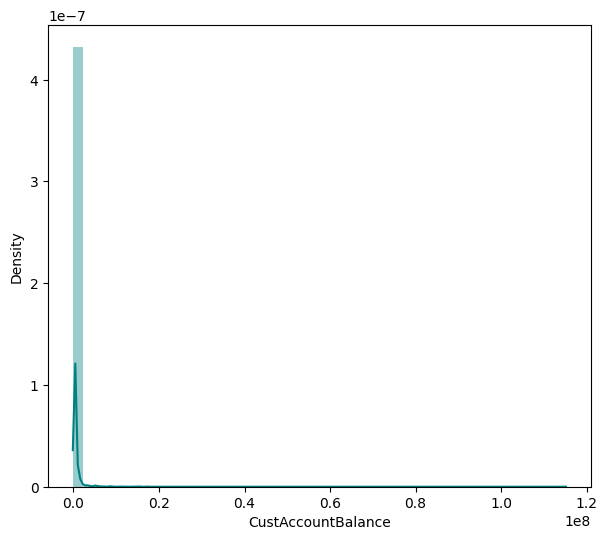


 
 Box Plot of CustAccountBalance:


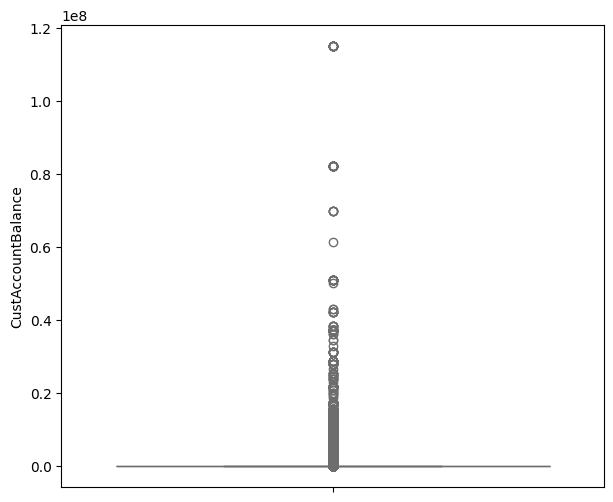

Quantile-Quantile Plot of CustAccountBalance: 

Skewness of TransactionAmount (INR): 57.002629271622524
Kurtosis of TransactionAmount (INR): 9037.44393341334

 
 Distribution Plot of TransactionAmount (INR): 


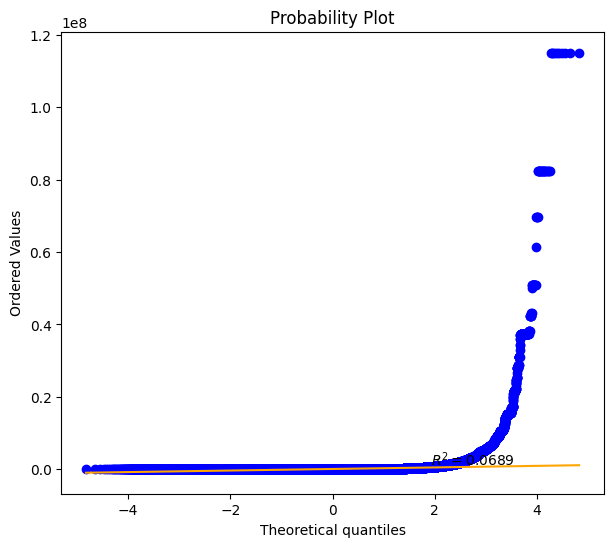

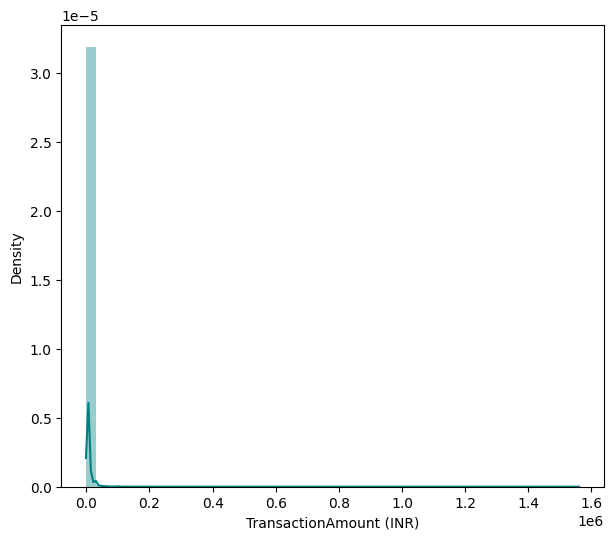


 
 Box Plot of TransactionAmount (INR):


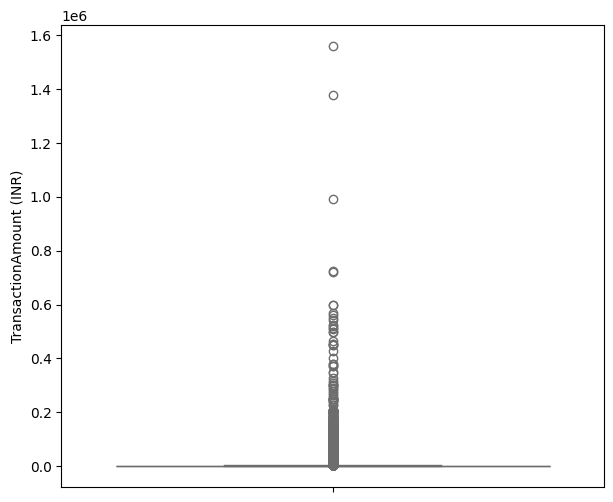

Quantile-Quantile Plot of TransactionAmount (INR): 



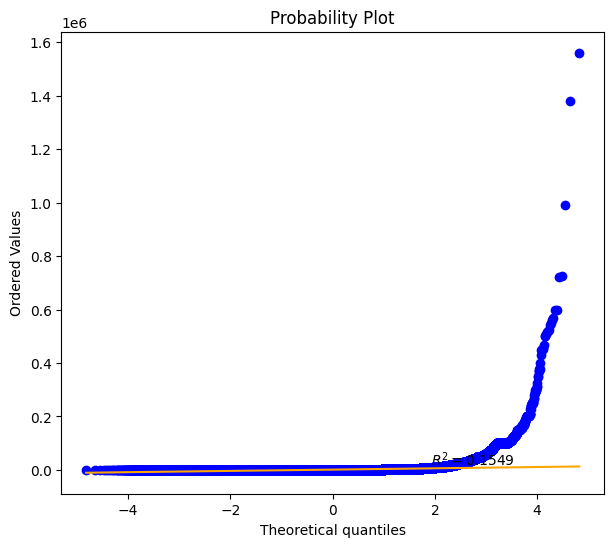

In [23]:
for col in df.columns:
    if df[col].dtype == np.float64:
        print("Skewness of {}:".format(col), df[col].skew())
        print("Kurtosis of {}:".format(col), df[col].kurt())

        # Distribution Plot
        plt.figure(figsize=(7,6))
        print("\n \n Distribution Plot of {}: ".format(col))
        sns.distplot(df[col], color='teal')  # Changed color to 'teal'
        plt.show()

        # Box Plot
        print("\n \n Box Plot of {}:".format(col))
        plt.figure(figsize=(7,6))
        sns.boxplot(df[col], color='salmon')  # Changed color to 'salmon'
        plt.show()

        # Quantile-Quantile Plot
        print("Quantile-Quantile Plot of {}: \n".format(col))
        plt.figure(figsize=(7,6))
        probplot(df[col], plot=plt, rvalue=True)
        plt.gca().get_lines()[1].set_color('orange')  # Changed Q-Q plot line color to 'orange'

In [24]:
df['CustGender'].value_counts()

CustGender
M    713801
F    273485
Name: count, dtype: int64

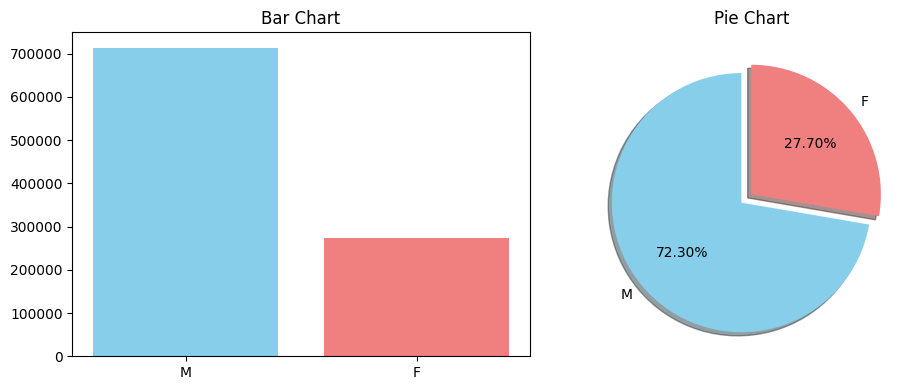

In [25]:
import matplotlib.pyplot as plt

labels = df['CustGender'].value_counts().index
values = df['CustGender'].value_counts().values
colors = ['skyblue','lightcoral']
explode = (0.1, 0)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Bar Chart
axs[0].bar(labels, values, color=colors)
axs[0].set_title("Bar Chart")

# Pie Chart
axs[1].pie(values, labels=labels, colors=colors, explode=explode,
           autopct='%1.2f%%', shadow=True, startangle=90)
axs[1].set_title("Pie Chart")

plt.tight_layout()
plt.show()


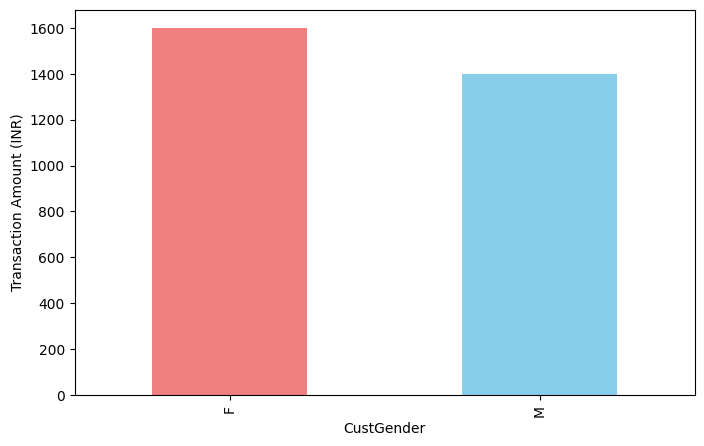

In [26]:
plt.figure(figsize=(8,5))
ax = df.groupby('CustGender')['TransactionAmount (INR)'].mean().plot(kind='bar',color=['lightcoral','skyblue'])
plt.ylabel('Transaction Amount (INR)');

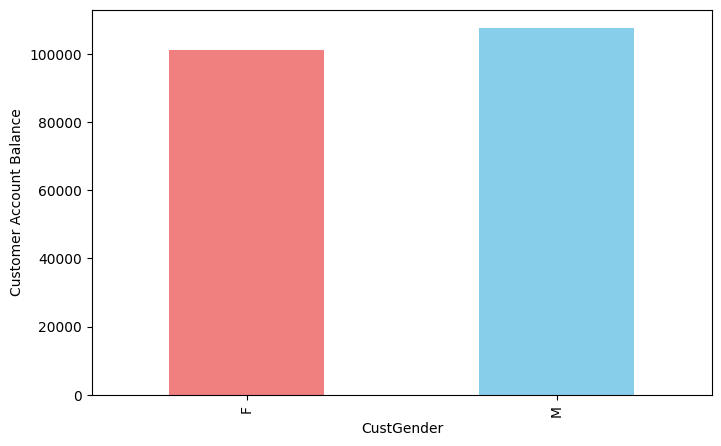

In [27]:
plt.figure(figsize=(8,5))
ax = df.groupby('CustGender')['CustAccountBalance'].mean().plot(kind='bar',color=['lightcoral','skyblue'])
plt.ylabel('Customer Account Balance');

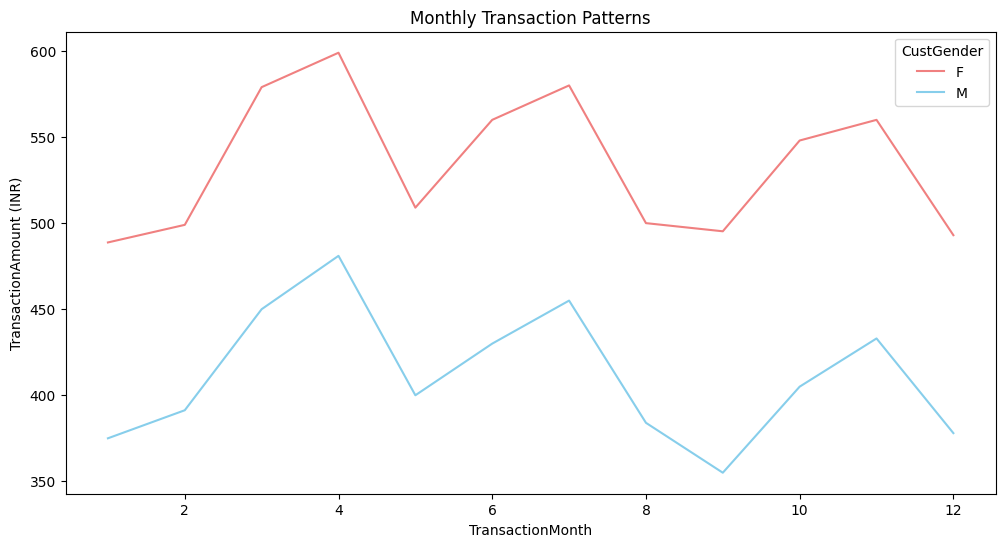

In [28]:
plt.figure(figsize=(12,6))
colors = ['lightcoral','skyblue']

sns.lineplot(data=df,x='TransactionMonth',y='TransactionAmount (INR)',hue='CustGender',
             palette=colors,estimator='median',errorbar=None)

plt.title('Monthly Transaction Patterns')
plt.show()

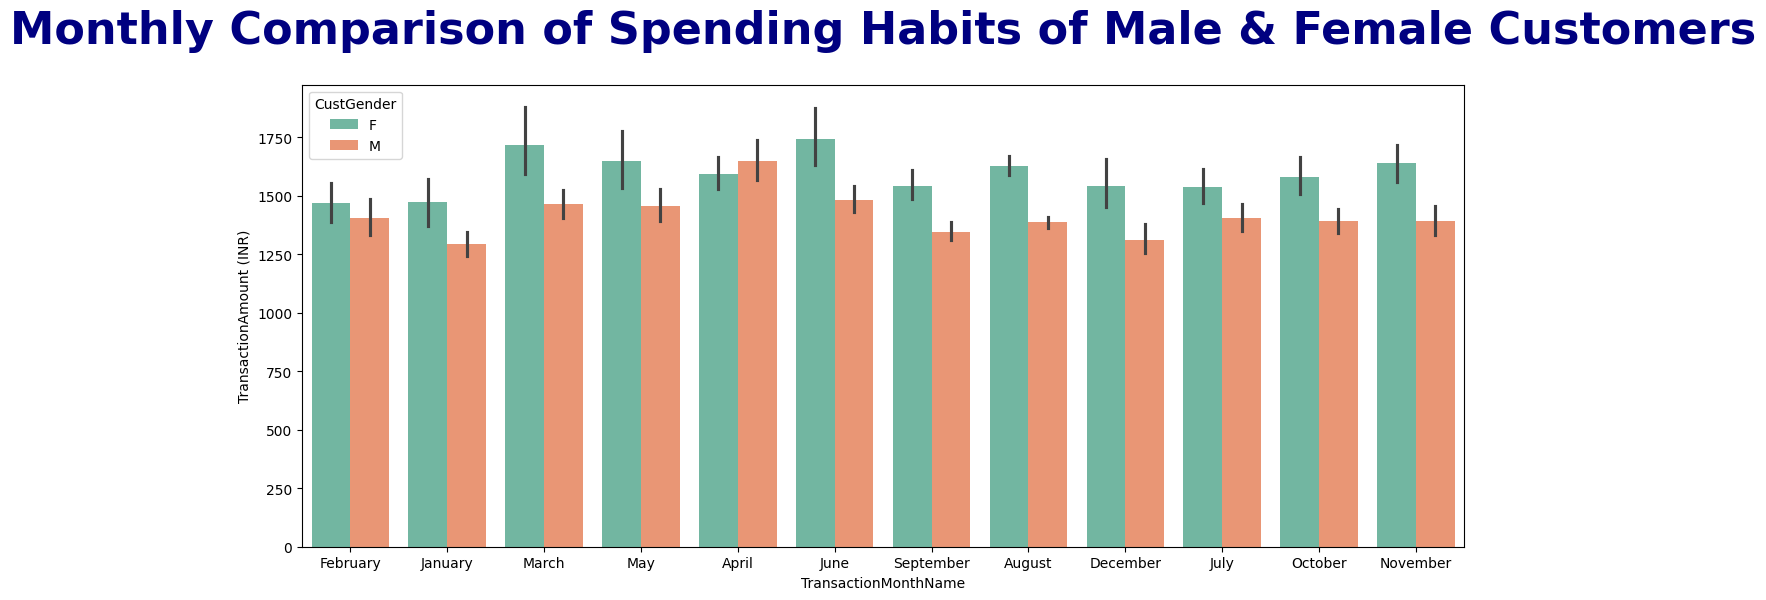

In [29]:
plt.figure(figsize=(15,6))
sns.barplot(data=df,x='TransactionMonthName',y='TransactionAmount (INR)',palette='Set2',hue='CustGender')
plt.title('Monthly Comparison of Spending Habits of Male & Female Customers',fontsize=32,fontweight='bold',color='navy',pad=30);

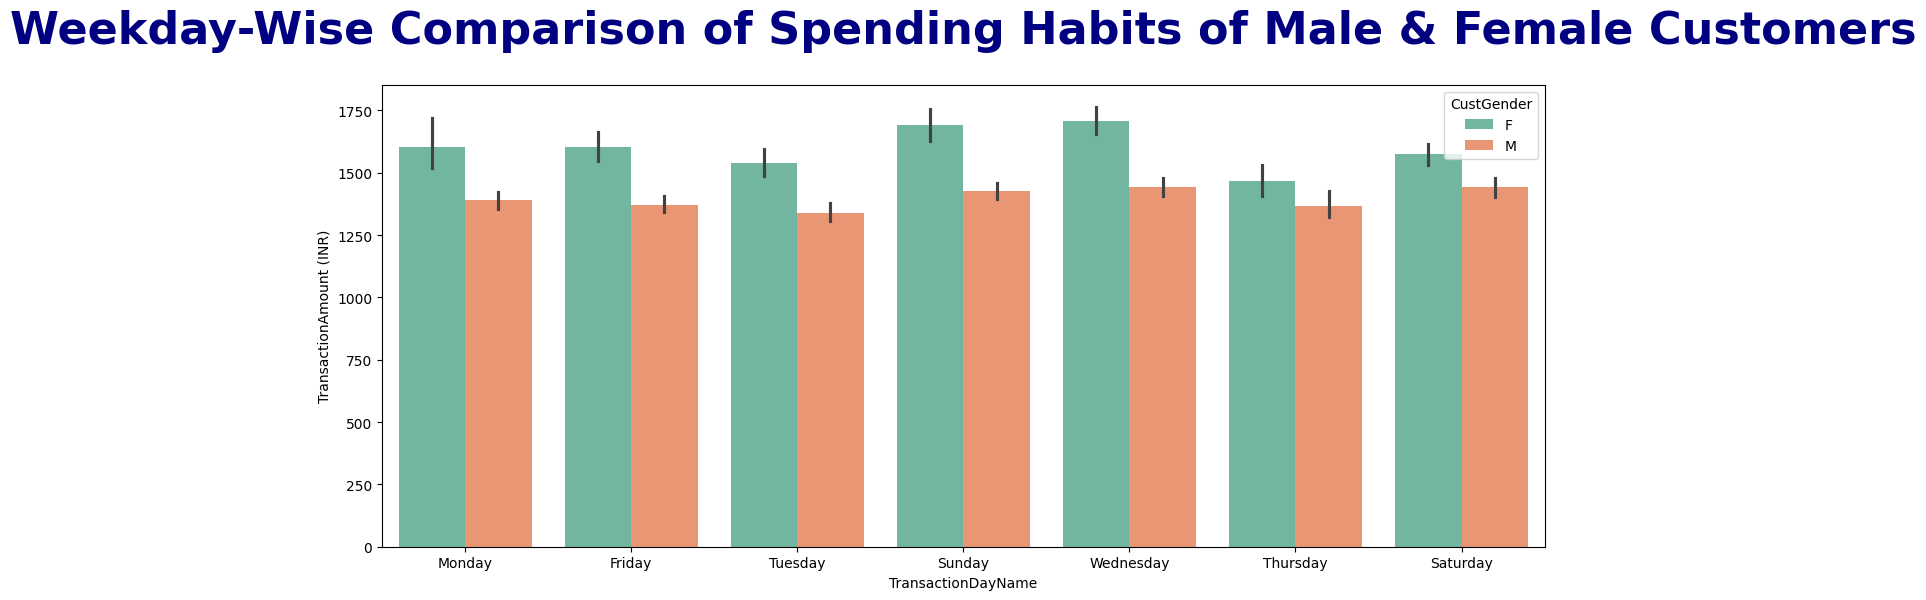

In [30]:
plt.figure(figsize=(15,6))
sns.barplot(data=df,x='TransactionDayName',y='TransactionAmount (INR)',palette='Set2',hue='CustGender')
plt.title('Weekday-Wise Comparison of Spending Habits of Male & Female Customers',fontsize=32,fontweight='bold',color='navy',pad=30);

Text(0.5, 1.0, 'Monthly Comparison of Account Balances of Male & Female Customers')

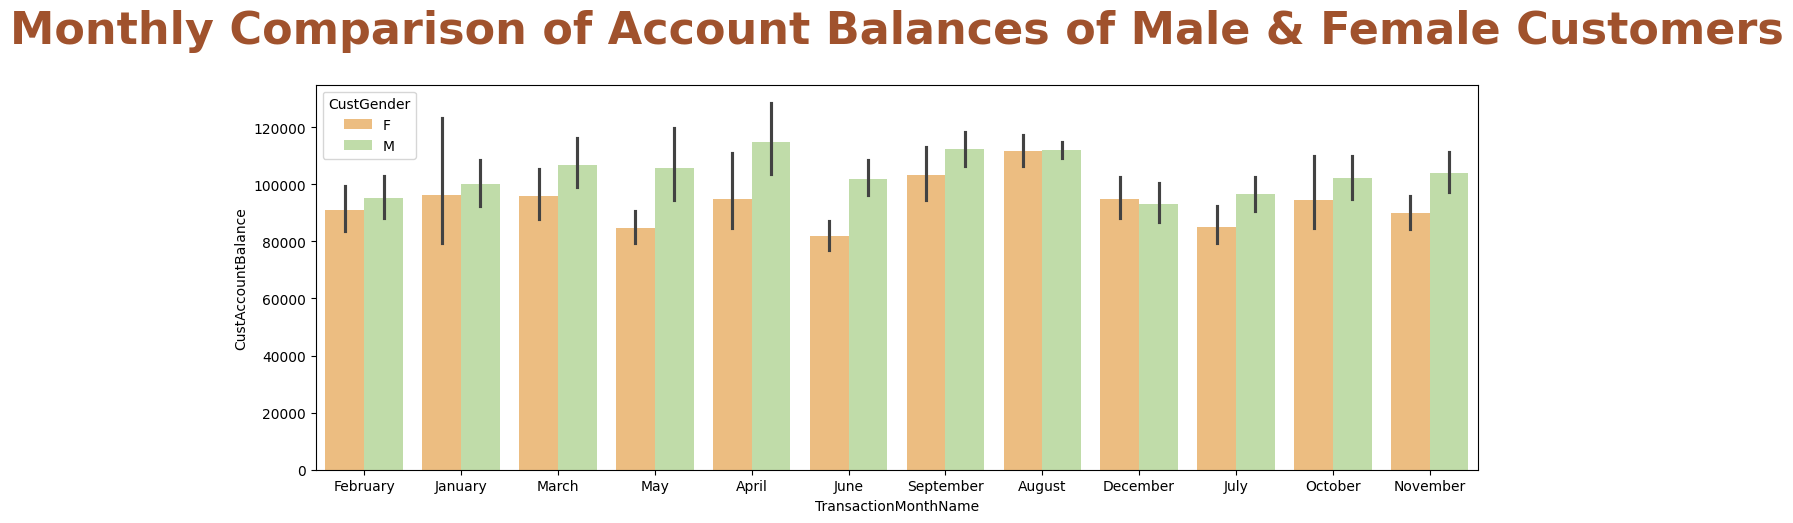

In [31]:
plt.figure(figsize=(15,5))
sns.barplot(data=df,x='TransactionMonthName',y='CustAccountBalance',palette='Spectral',hue='CustGender')
plt.title('Monthly Comparison of Account Balances of Male & Female Customers',fontsize=32,fontweight='bold',color='sienna',pad=30)


<Axes: xlabel='TransactionMonthName', ylabel='TransactionAmount (INR)'>

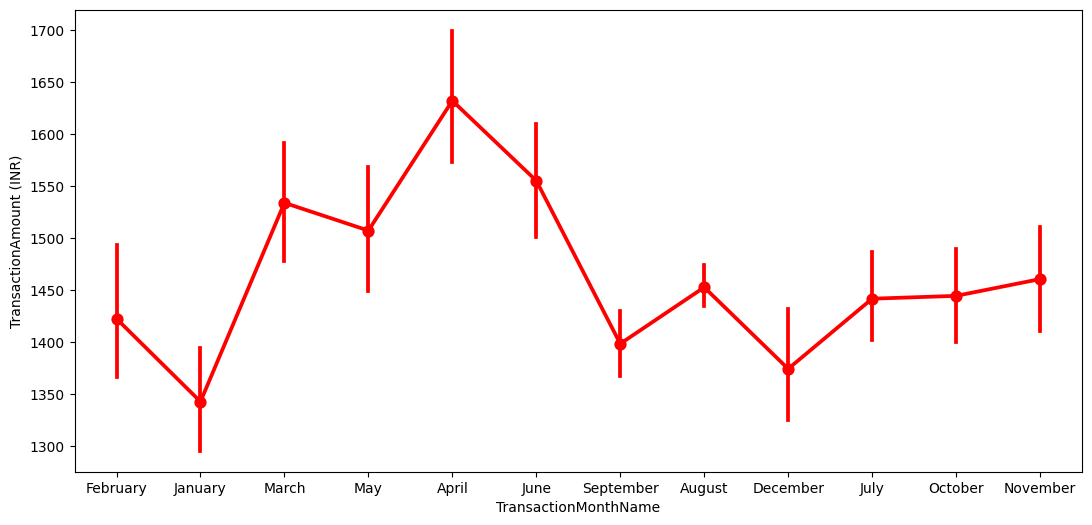

In [32]:
plt.figure(figsize=(13,6))
sns.pointplot(data=df,x='TransactionMonthName',y='TransactionAmount (INR)',color='red')

In [ ]:
plt.figure(figsize=(13,6))
sns.pointplot(data=df,x='TransactionMonthName',y='CustAccountBalance',color='green')

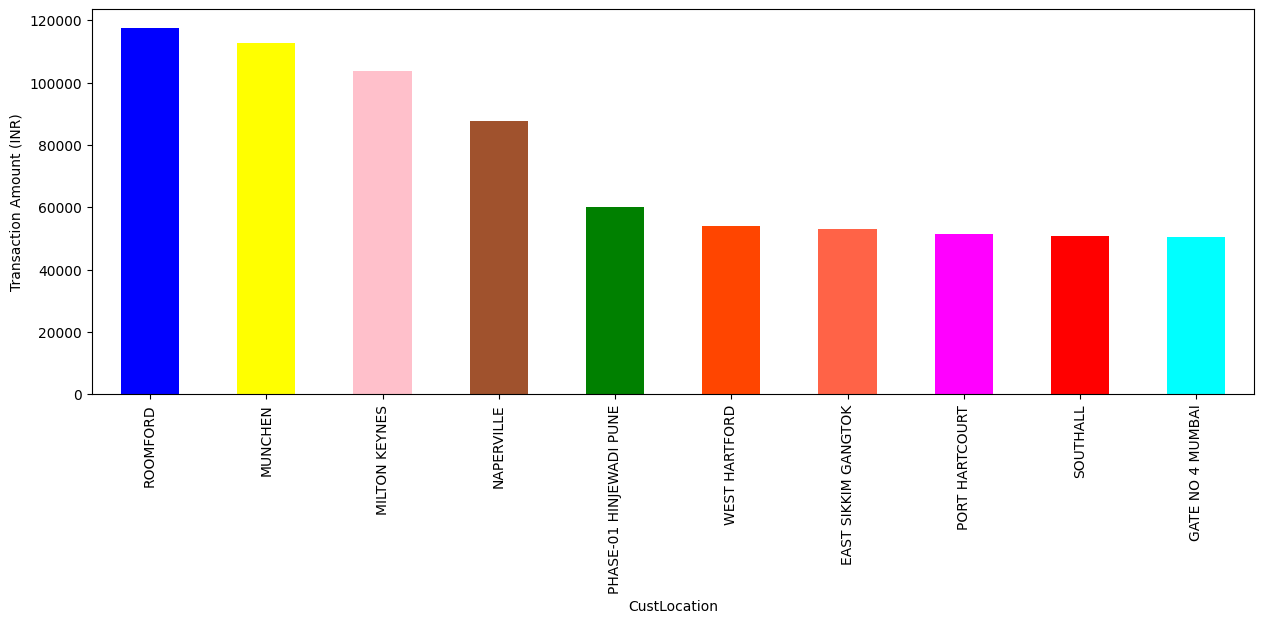

In [34]:
plt.figure(figsize=(15,5))
df.groupby('CustLocation')['TransactionAmount (INR)'].mean().sort_values(ascending=False)[:10].plot(kind='bar',color=['blue','yellow','pink','sienna','green','orangered','tomato','magenta','red','cyan'])
plt.ylabel('Transaction Amount (INR)');

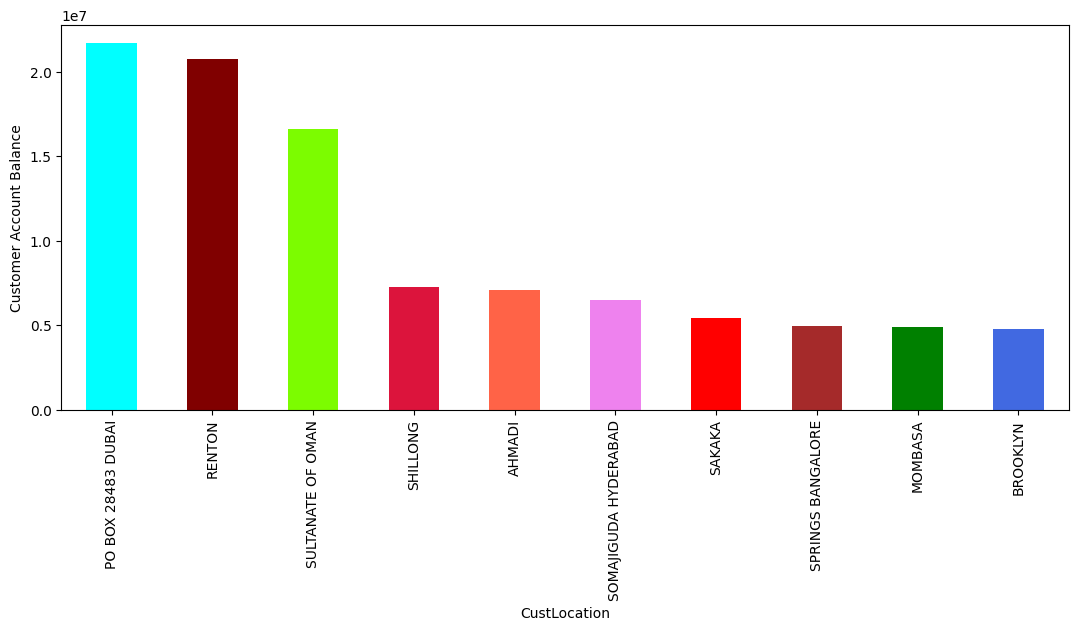

In [35]:
plt.figure(figsize=(13,5))
df.groupby('CustLocation')['CustAccountBalance'].mean().sort_values(ascending=False)[:10].plot(kind='bar',color=['aqua','maroon','lawngreen','crimson','tomato','violet','red','brown','green','royalblue'])
plt.ylabel('Customer Account Balance');

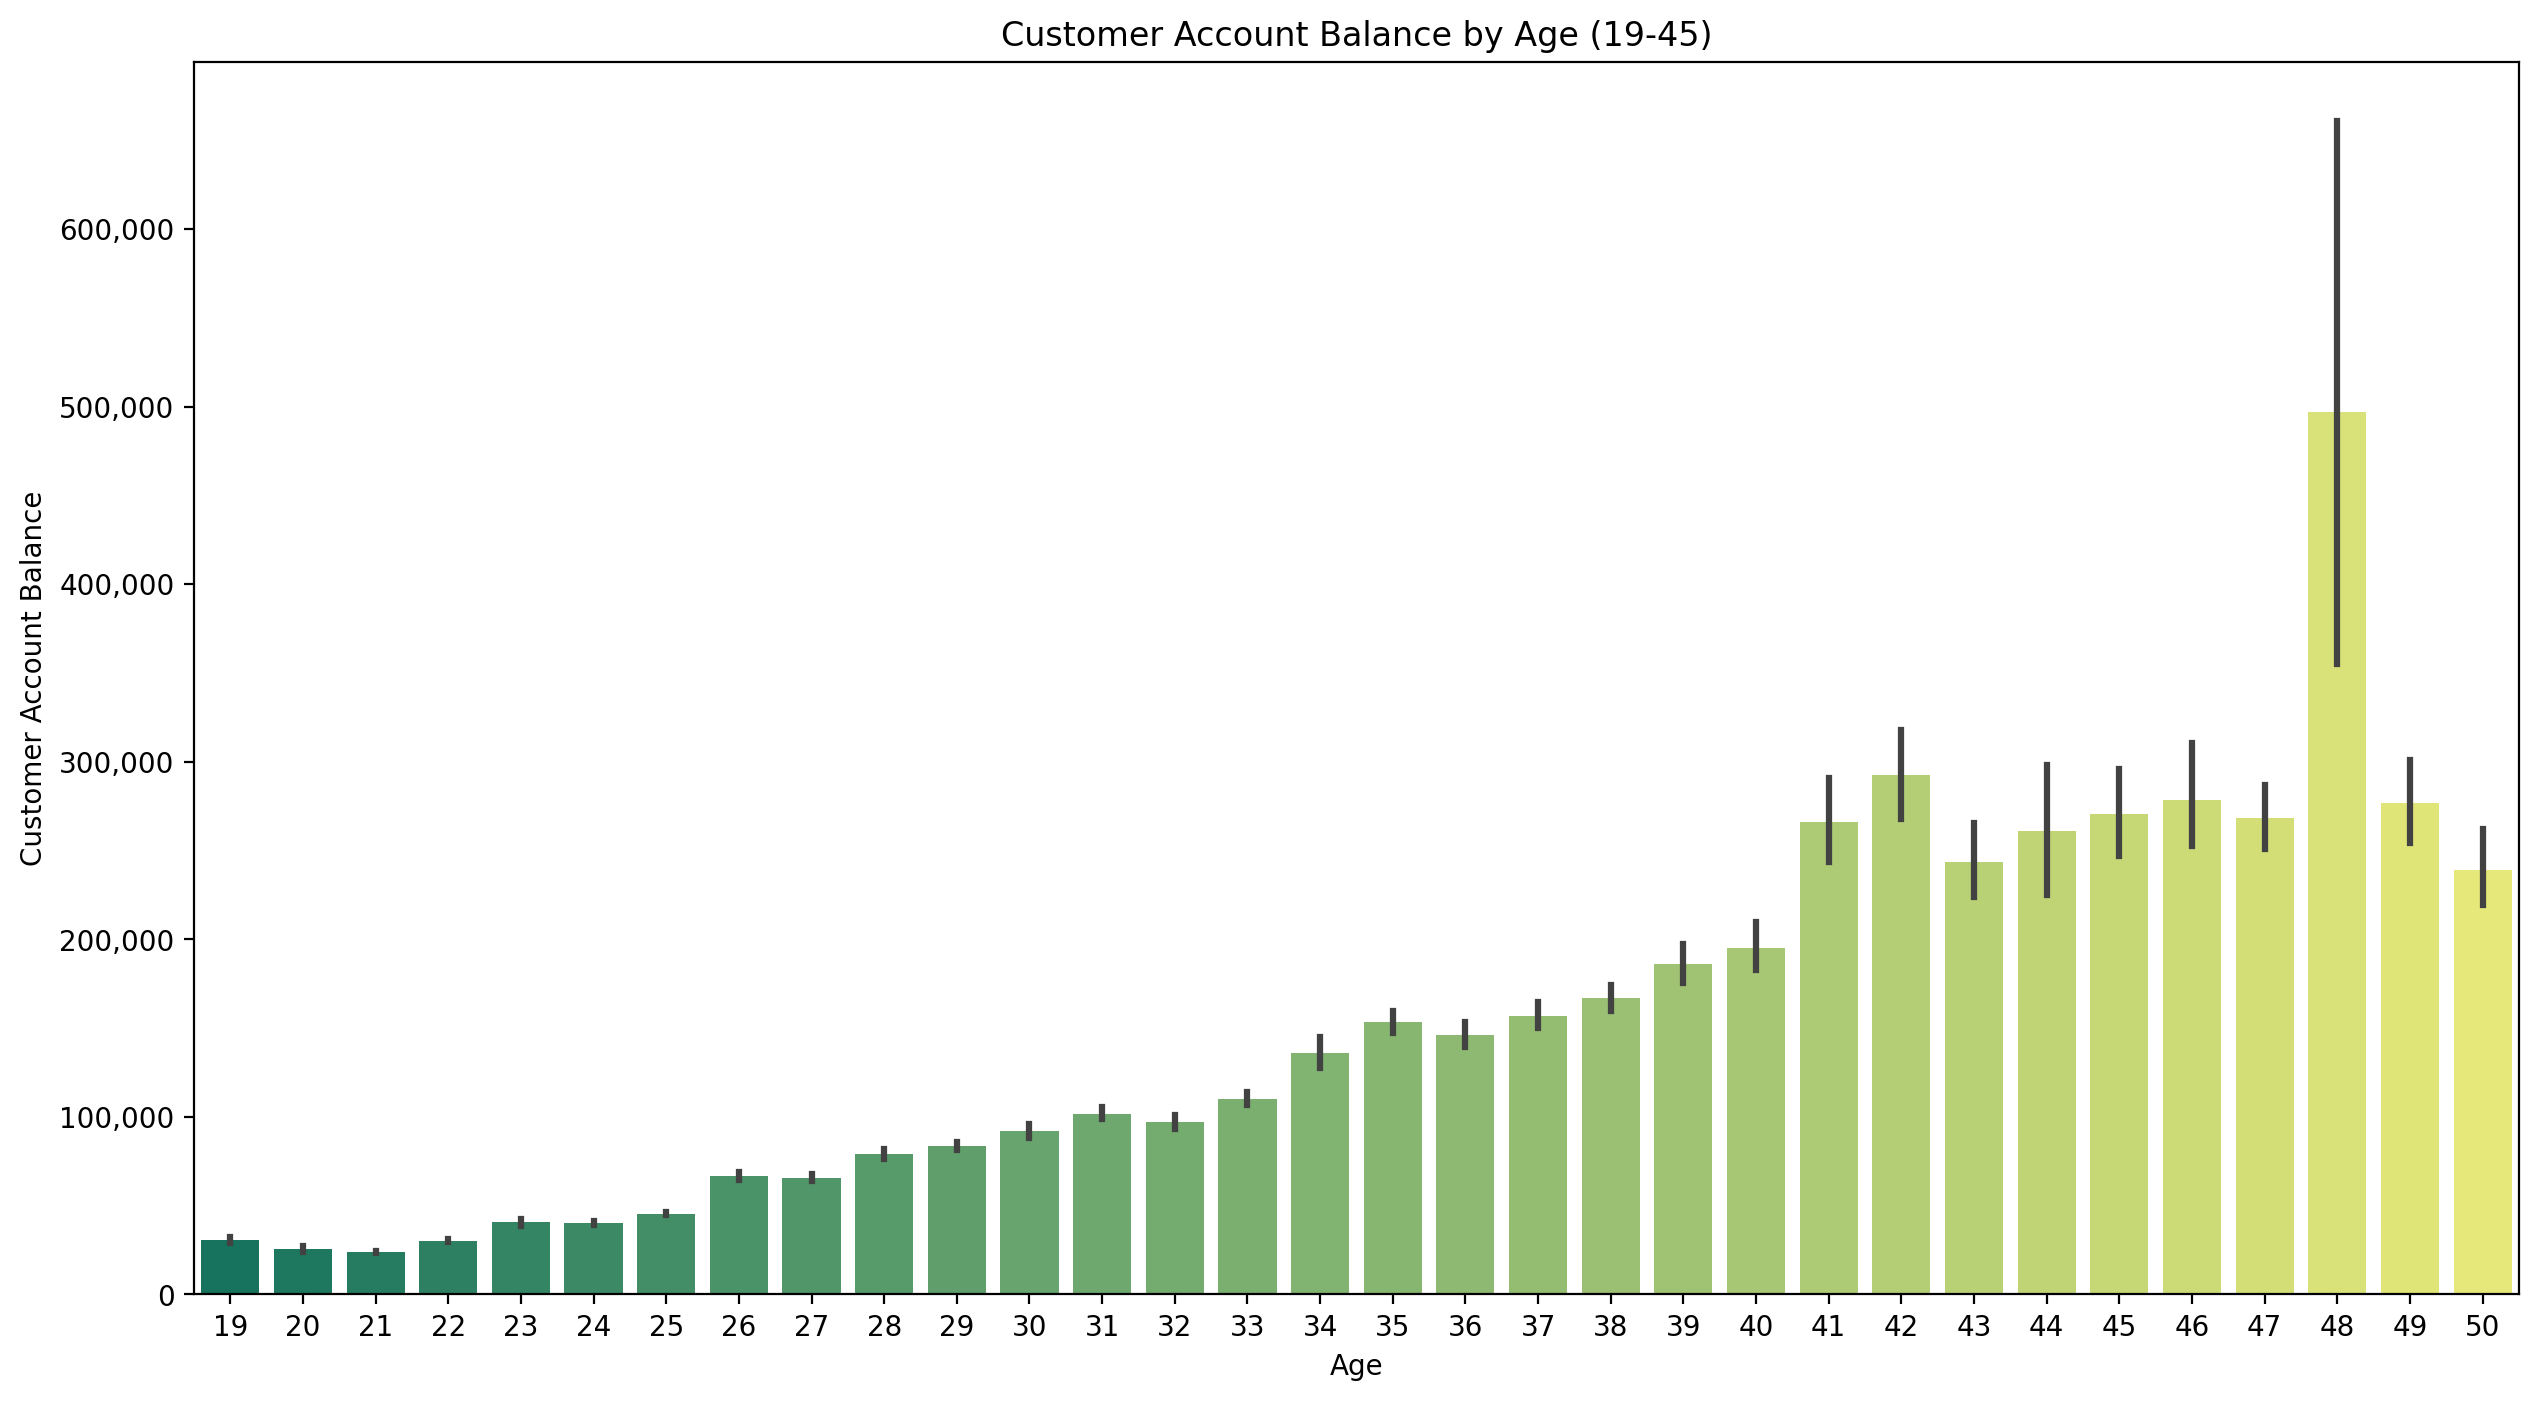

In [36]:
# Filter DataFrame for age between 19 and 50
filtered_df = df[(df['Age'] >= 19) & (df['Age'] <= 50)]

# Plotting
plt.figure(figsize=(15, 8), dpi=200)
sns.barplot(data=filtered_df, x='Age', y='CustAccountBalance', palette='summer')

# Set y-axis formatter to display full numbers
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.xlabel('Age')
plt.ylabel('Customer Account Balance')
plt.title('Customer Account Balance by Age (19-45)')
plt.show()

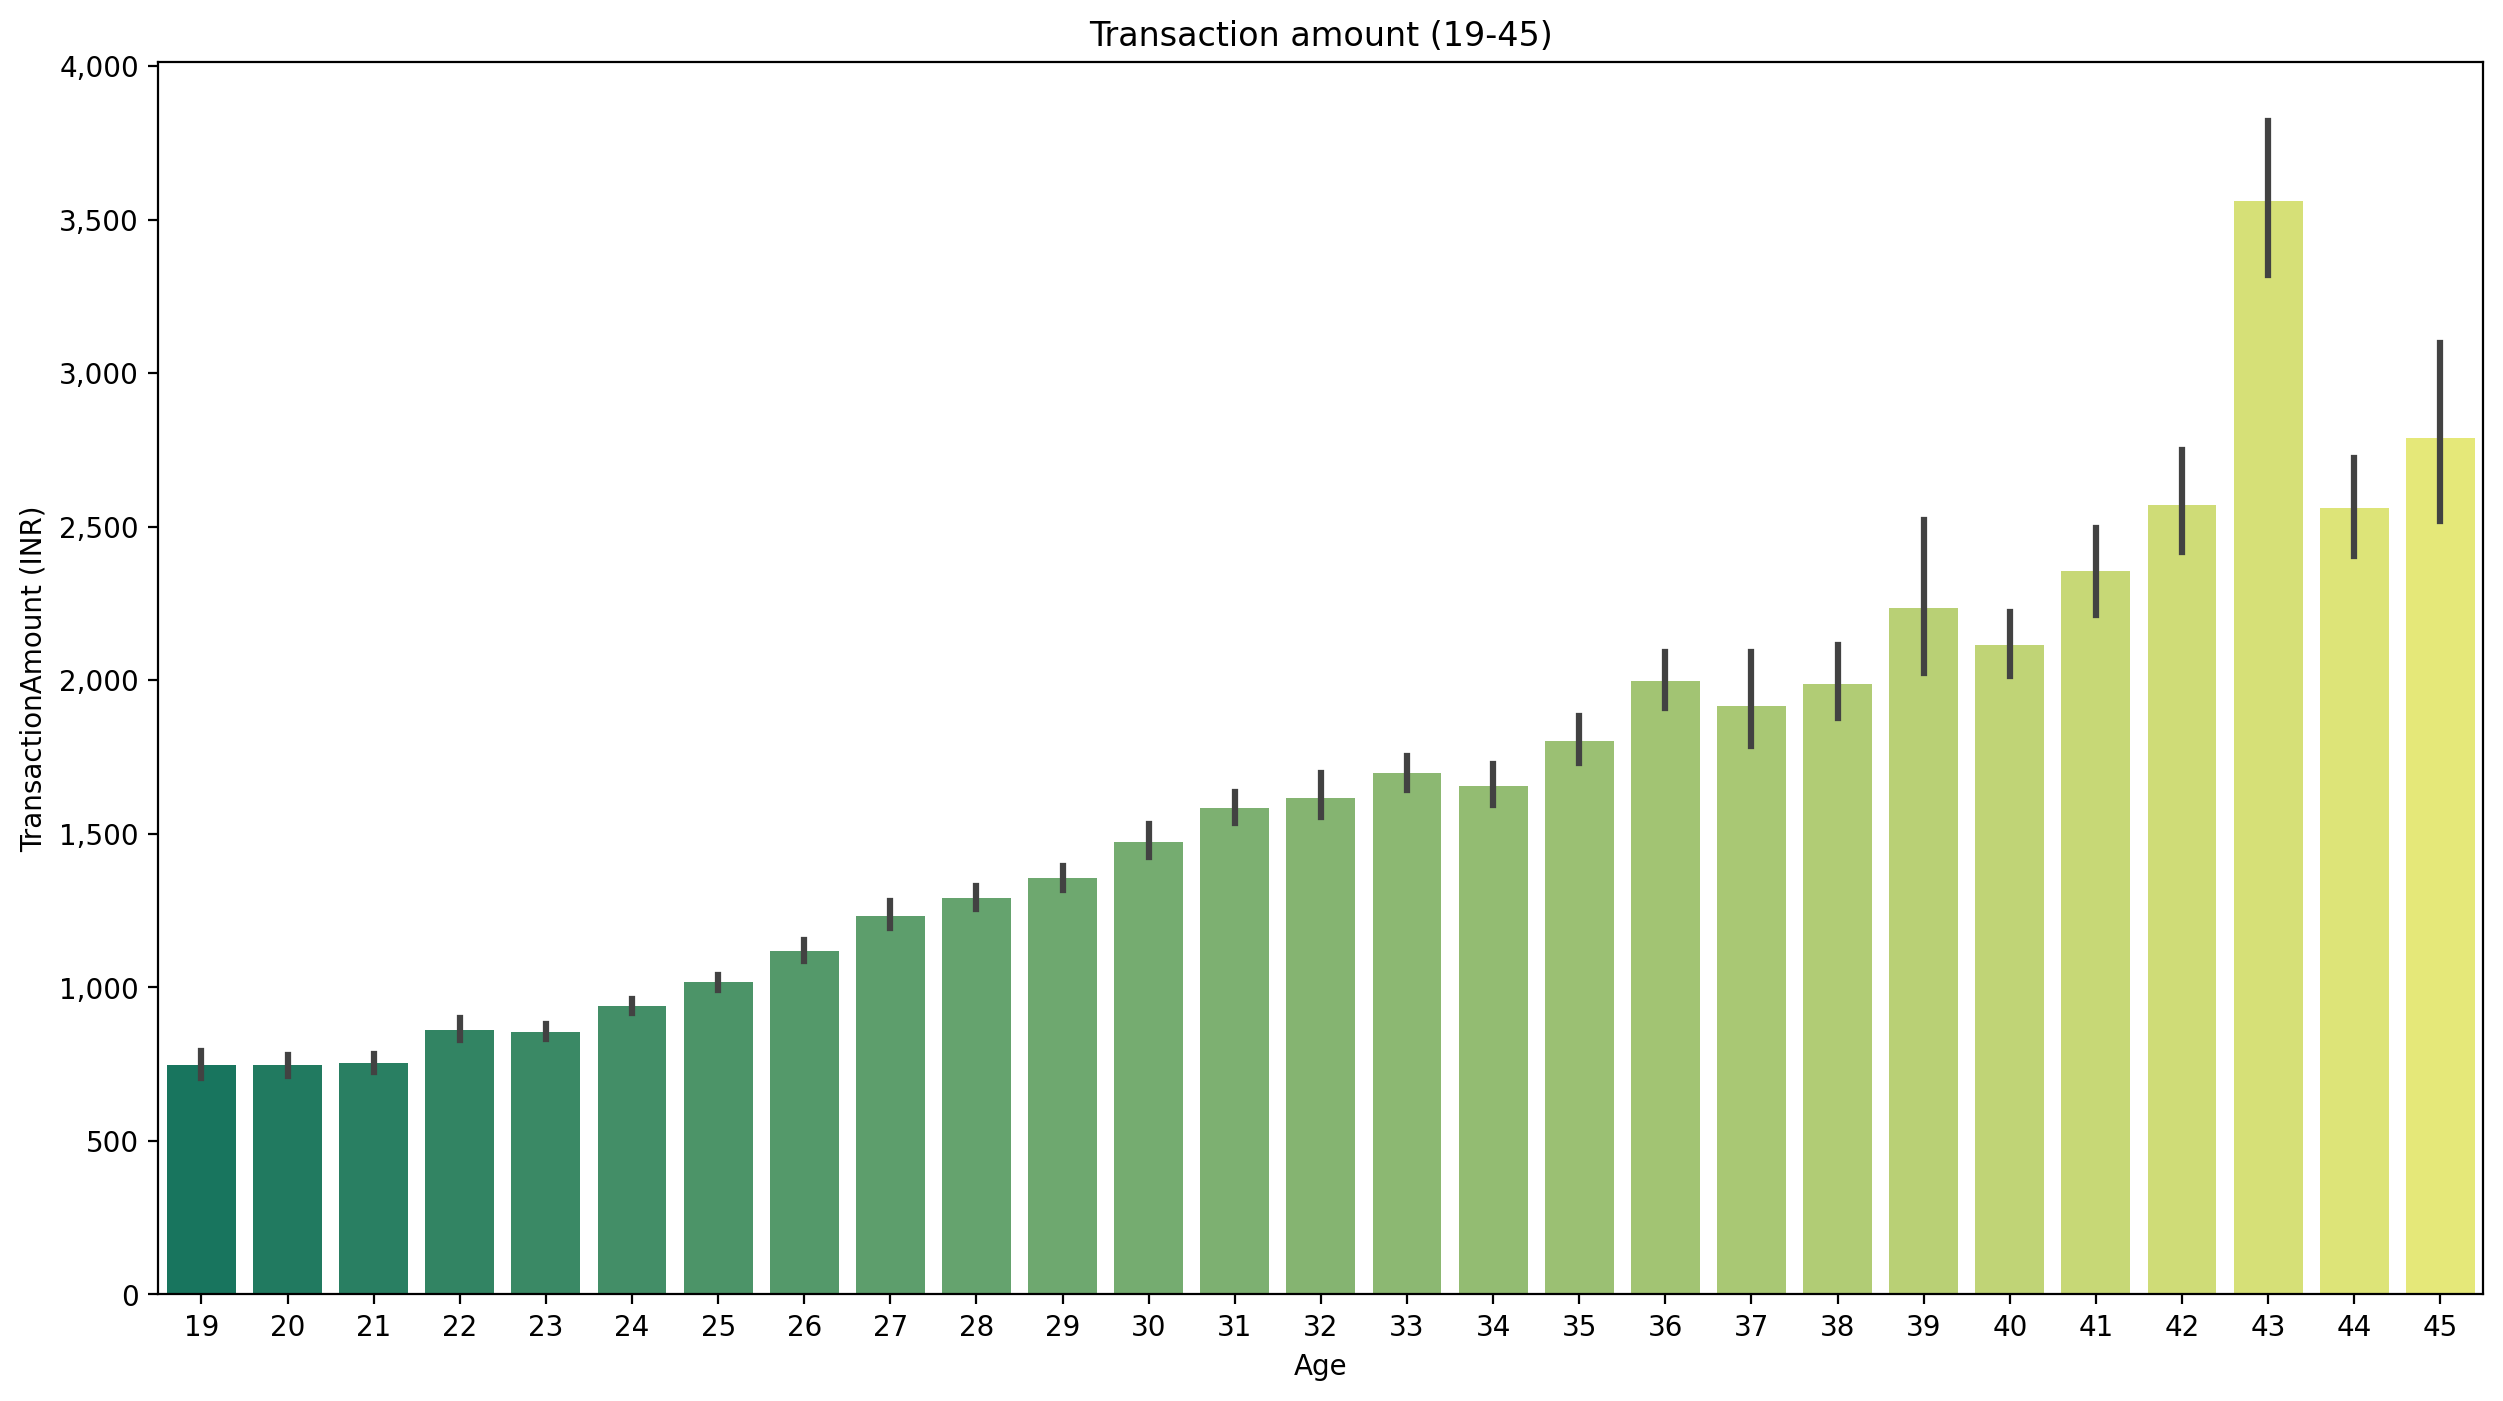

In [37]:
# Filter DataFrame for age between 19 and 45
filtered_df = df[(df['Age'] >= 19) & (df['Age'] <= 45)]

# Plotting
plt.figure(figsize=(15, 8), dpi=200)
sns.barplot(data=filtered_df, x='Age', y='TransactionAmount (INR)', palette='summer')

# Set y-axis formatter to display full numbers
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.xlabel('Age')
plt.ylabel('TransactionAmount (INR)')
plt.title('Transaction amount (19-45)')
plt.show()

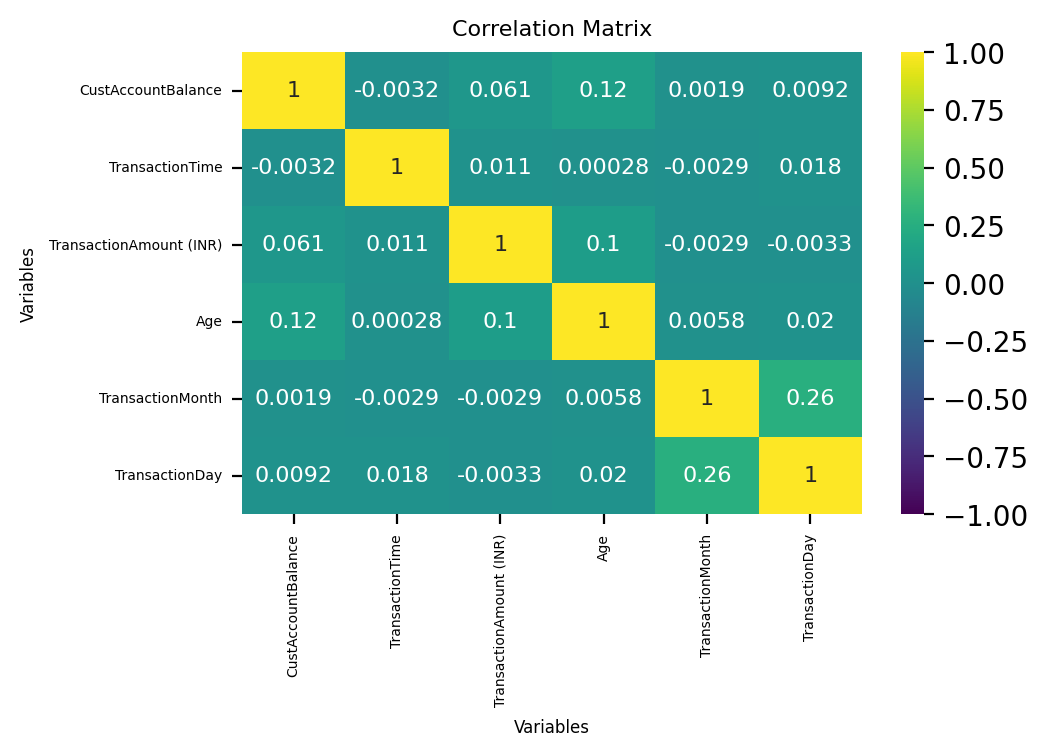

In [38]:
# Convert or drop non-numeric columns
df_numeric = df.select_dtypes(include=[float, int])



# Compute correlation matrix
corr_matrix = df_numeric.corr()

# Plot heatmap with reduced text size
plt.figure(figsize=(5, 3), dpi=200)
ax = sns.heatmap(corr_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1, annot_kws={"size": 8})

# Reduce text size for axis labels and title
ax.set_xlabel('Variables', fontsize=6)
ax.set_ylabel('Variables', fontsize=6)
ax.set_title('Correlation Matrix', fontsize=8)

# Adjust tick label size
ax.tick_params(axis='both', which='major', labelsize=5)

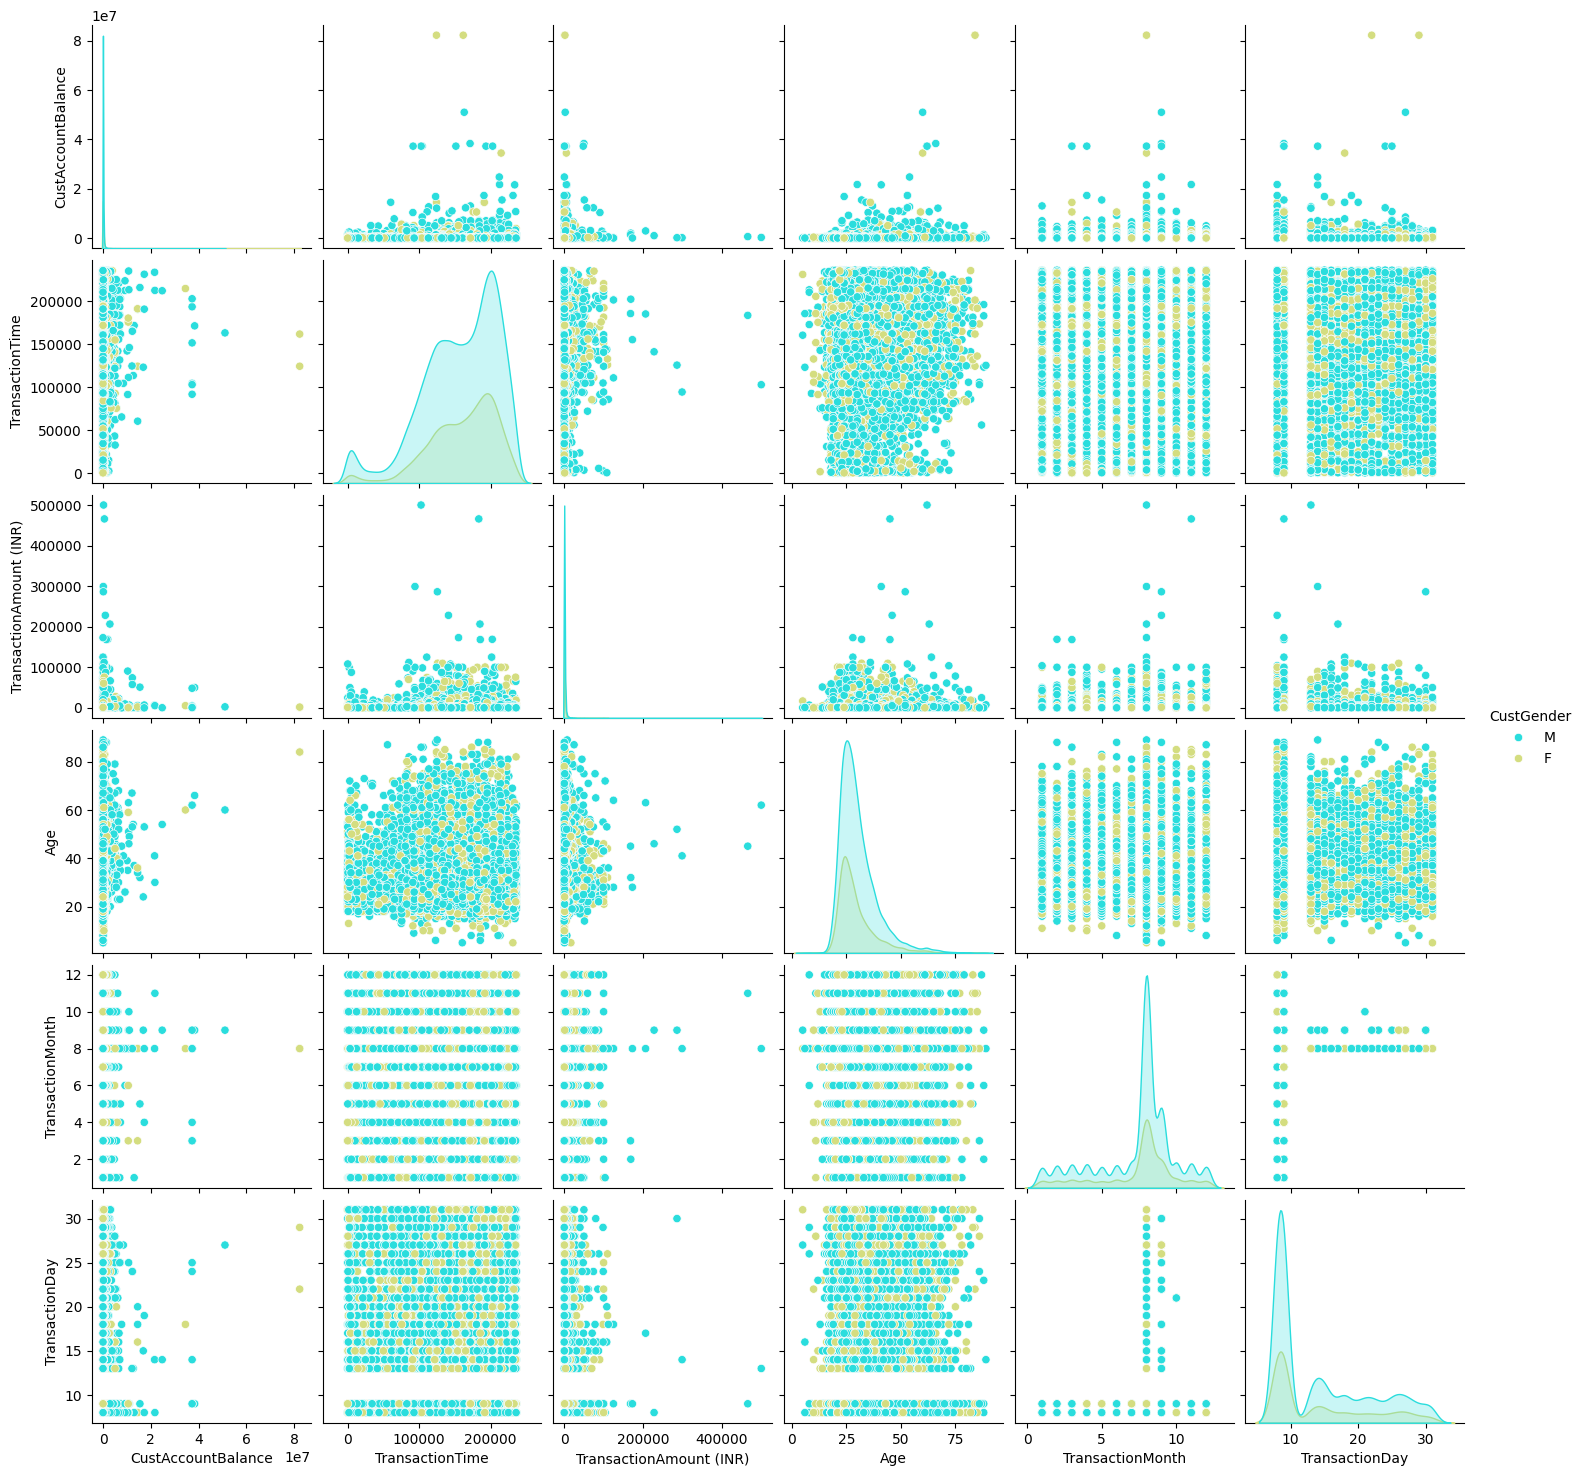

In [39]:
sns.pairplot(df.sample(n=50000),hue='CustGender',palette='rainbow')

In [40]:
df.CustGender.replace(['F','M'],[0,1],inplace=True)
df.CustGender = df.CustGender.astype(np.int64)

# Categorical Encoding :

In [41]:
encoder = LabelEncoder()
df.CustLocation = encoder.fit_transform(df.CustLocation)
df.CustLocation = df.CustLocation.astype(np.int64)

In [42]:
df.drop(['TransactionMonthName','TransactionDayName'],axis=1,inplace=True)

# Feature Scaling :

In [43]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
scaled_df.head()

,CustGender,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),Age,TransactionMonth,TransactionDay
0,-1.615555,-0.230271,-0.107742,-0.277282,-0.232404,-1.032959,-2.030652,-0.879712
1,0.618982,-0.202922,-0.126772,-0.303592,4.318326,3.196117,-2.030652,-0.879712
2,-1.615555,0.493278,-0.107674,-0.286936,-0.161802,-1.261557,-2.030652,-0.879712
3,-1.615555,0.493278,0.930964,-0.286897,0.098644,1.367327,-2.030652,-0.879712
4,-1.615555,0.656412,-0.121333,0.462859,0.050248,-0.347163,-2.030652,-0.879712


# Unsupervised Machine Learning : 

In [44]:
temp = scaled_df.sample(n=50000)

# K Means Clustering : 

In [45]:
base_kmeans = KMeans(random_state=101)
base_kmeans.fit(temp)

KMeans(random_state=101)

In [46]:
labels = set(base_kmeans.labels_)
labels

{np.int32(0),
 np.int32(1),
 np.int32(2),
 np.int32(3),
 np.int32(4),
 np.int32(5),
 np.int32(6),
 np.int32(7)}

In [47]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,base_kmeans.labels_)*100,2)) + '%')

Silhouette Score: 18.37%


In [48]:
from sklearn.cluster import KMeans
import numpy as np


for i in range(1, 11):
    for init in ['k-means++', 'random']:
        for algo in ['lloyd', 'elkan']:  # Use 'lloyd' and 'elkan' as valid options
            kmeans = KMeans(n_clusters=i, init=init, algorithm=algo, random_state=101)
            kmeans.fit(temp)
            print("Number of Clusters: {}".format(i))
            print("Initialization Algorithm: {}".format(init))
            print("Algorithm: {}".format(algo))
            print("Sum of Squared Distance: %d" % kmeans.inertia_)
            print('-----------------')


Number of Clusters: 1
Initialization Algorithm: k-means++
Algorithm: lloyd
Sum of Squared Distance: 373303
-----------------
Number of Clusters: 1
Initialization Algorithm: k-means++
Algorithm: elkan
Sum of Squared Distance: 373303
-----------------
Number of Clusters: 1
Initialization Algorithm: random
Algorithm: lloyd
Sum of Squared Distance: 373303
-----------------
Number of Clusters: 1
Initialization Algorithm: random
Algorithm: elkan
Sum of Squared Distance: 373303
-----------------
Number of Clusters: 2
Initialization Algorithm: k-means++
Algorithm: lloyd
Sum of Squared Distance: 331674
-----------------
Number of Clusters: 2
Initialization Algorithm: k-means++
Algorithm: elkan
Sum of Squared Distance: 331674
-----------------
Number of Clusters: 2
Initialization Algorithm: random
Algorithm: lloyd
Sum of Squared Distance: 323269
-----------------
Number of Clusters: 2
Initialization Algorithm: random
Algorithm: elkan
Sum of Squared Distance: 323269
-----------------
Number of Cl

In [49]:
optimized_kmeans = KMeans(n_clusters=10,init='k-means++',algorithm='elkan',random_state=101)
optimized_kmeans.fit(temp)
print("Silhouette Score:",str(np.round(silhouette_score(temp,optimized_kmeans.labels_)*100,2)) + '%')

Silhouette Score: 19.17%


In [50]:
print("Estimated number of clusters:", len(set(optimized_kmeans.labels_)), set(optimized_kmeans.labels_))
print("Estimated number of noise points:", list(optimized_kmeans.labels_).count(-1))

Estimated number of clusters: 10 {np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9)}
Estimated number of noise points: 0


<Axes: xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

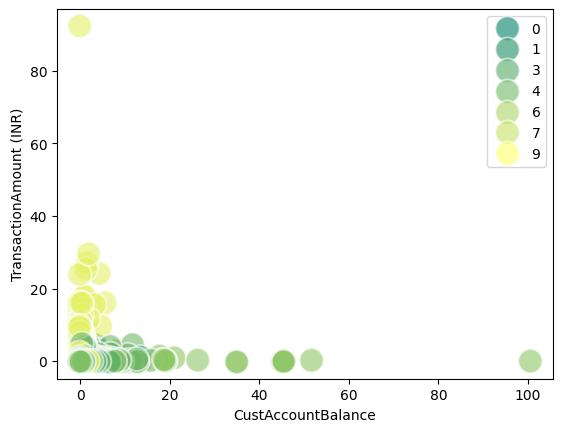

In [51]:
sns.scatterplot(data=temp,x='CustAccountBalance',y='TransactionAmount (INR)',hue=optimized_kmeans.labels_,s=300,alpha=0.6,palette='summer')


In [52]:
from clusteval import clusteval
ce = clusteval(cluster='kmeans',savemem=True,verbose=4)
results = ce.fit(np.reshape(np.ravel(temp.sample(1000)),(-1,1)))
cluster_labels = results['labx']

[09-09-2025 00:41:29] [clusteval.clusteval] [INFO] Saving data in memory.
[09-09-2025 00:41:29] [clusteval.clusteval] [INFO] Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[09-09-2025 00:41:29] [clusteval.silhouette] [INFO] Evaluate using silhouette.
[09-09-2025 00:41:29] [clusteval.silhouette] [INFO] Save memory enabled for kmeans with evaluation silhouette.
[clusteval] >INFO: 100%|███████████████████████████████████████████████████████████████| 23/23 [00:32<00:00,  1.42s/it]
[09-09-2025 00:42:01] [clusteval.clusteval] [INFO] Optimal number clusters detected: [24].
[09-09-2025 00:42:01] [clusteval.clusteval] [INFO] Fin.


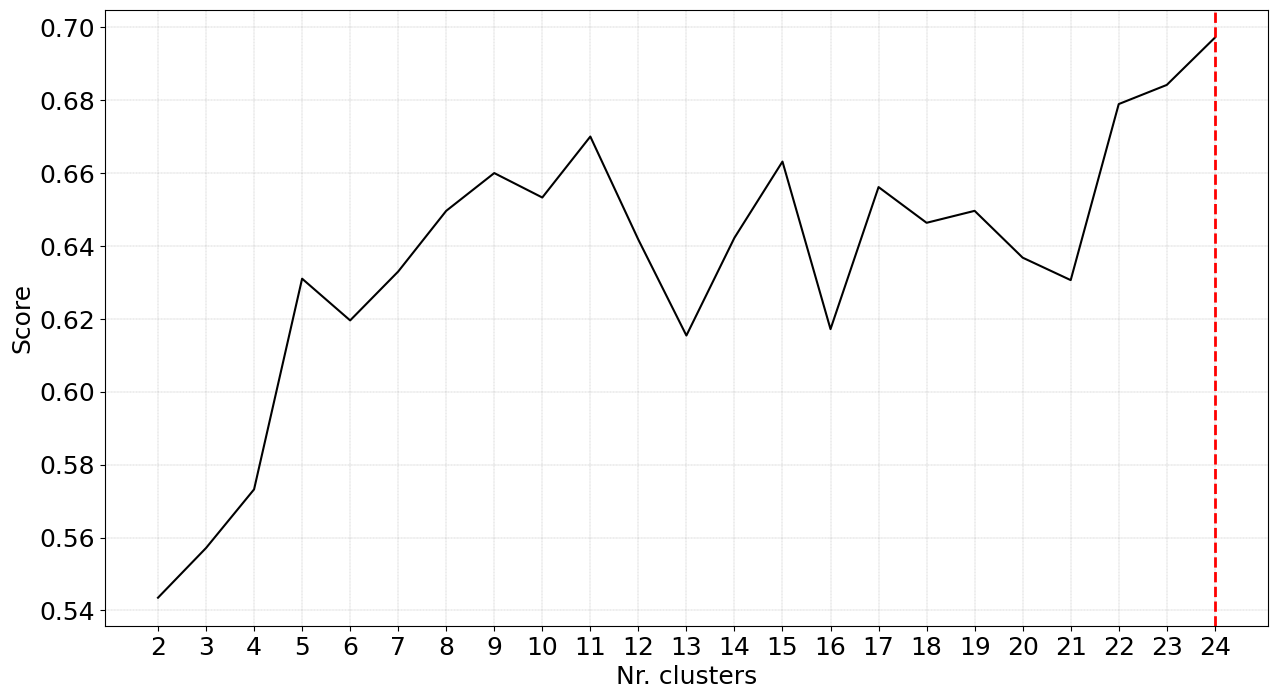

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [53]:
ce.plot()

# Hierarchical Clustering :

In [54]:
mmscaler = MinMaxScaler()
minmax_scaled_df = mmscaler.fit_transform(df)
minmax_scaled_df = pd.DataFrame(minmax_scaled_df,columns=df.columns)
minmax_scaled_df.head()

,CustGender,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),Age,TransactionMonth,TransactionDay
0,0.0,0.381845,0.000155,0.606915,0.000016,0.227273,0.090909,0.0
1,1.0,0.388828,0.000020,0.601198,0.017948,0.647727,0.090909,0.0
2,0.0,0.566581,0.000155,0.604817,0.000294,0.204545,0.090909,0.0
3,0.0,0.566581,0.007532,0.604825,0.001320,0.465909,0.090909,0.0
4,0.0,0.608232,0.000058,0.767744,0.001130,0.295455,0.090909,0.0


In [55]:
temp2 = minmax_scaled_df.sample(n=20000)

In [56]:
base_hc = AgglomerativeClustering()
base_hc.fit(temp2)

AgglomerativeClustering()

In [57]:
print("Estimated number of clusters:", set(base_hc.labels_))

Estimated number of clusters: {np.int64(0), np.int64(1)}


In [58]:
print("Estimated number of noise points:", list(base_hc.labels_).count(-1))

Estimated number of noise points: 0


In [59]:
print("Silhouette Score:",str(np.round(silhouette_score(temp2,base_hc.labels_)*100,2)) + '%')

Silhouette Score: 43.53%


<Axes: xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

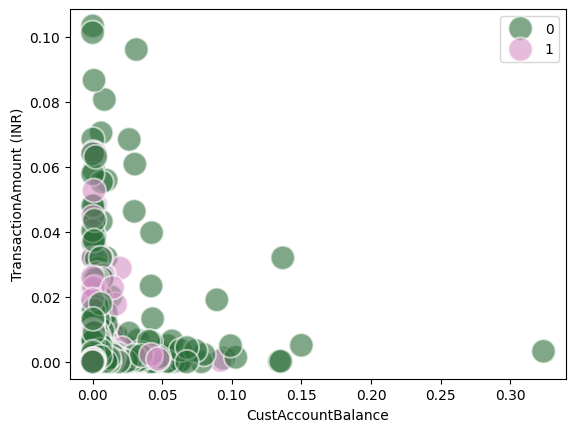

In [60]:
sns.scatterplot(x=temp2['CustAccountBalance'], y=temp2['TransactionAmount (INR)'], hue=base_hc.labels_, s=300, alpha=0.6, palette='cubehelix')

In [61]:
temp2_samp = temp2.sample(500)
ce = clusteval(verbose=4)
results = ce.fit(np.reshape(np.ravel(temp2_samp),(-1,1)))
results

[09-09-2025 00:42:42] [clusteval.clusteval] [INFO] Saving data in memory.
[09-09-2025 00:42:42] [clusteval.clusteval] [INFO] Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[09-09-2025 00:42:43] [clusteval.silhouette] [INFO] Evaluate using silhouette.
[clusteval] >INFO: 100%|███████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.52it/s]
[09-09-2025 00:42:52] [clusteval.clusteval] [INFO] Compute dendrogram threshold.
[09-09-2025 00:42:52] [clusteval.clusteval] [INFO] Optimal number clusters detected: [24].
[09-09-2025 00:42:52] [clusteval.clusteval] [INFO] Fin.


{'evaluate': 'silhouette',
 'score':     cluster_threshold  clusters     score
 0                   2         2  0.690387
 1                   3         3  0.713970
 2                   4         4  0.753866
 3                   5         5  0.740874
 4                   6         6  0.734482
 5                   7         7  0.742654
 6                   8         8  0.745798
 7                   9         9  0.728510
 8                  10        10  0.740588
 9                  11        11  0.758708
 10                 12        12  0.764145
 11                 13        13  0.772357
 12                 14        14  0.774489
 13                 15        15  0.780071
 14                 16        16  0.790272
 15                 17        17  0.784776
 16                 18        18  0.789793
 17                 19        19  0.798113
 18                 20        20  0.795468
 19                 21        21  0.789759
 20                 22        22  0.795608
 21               

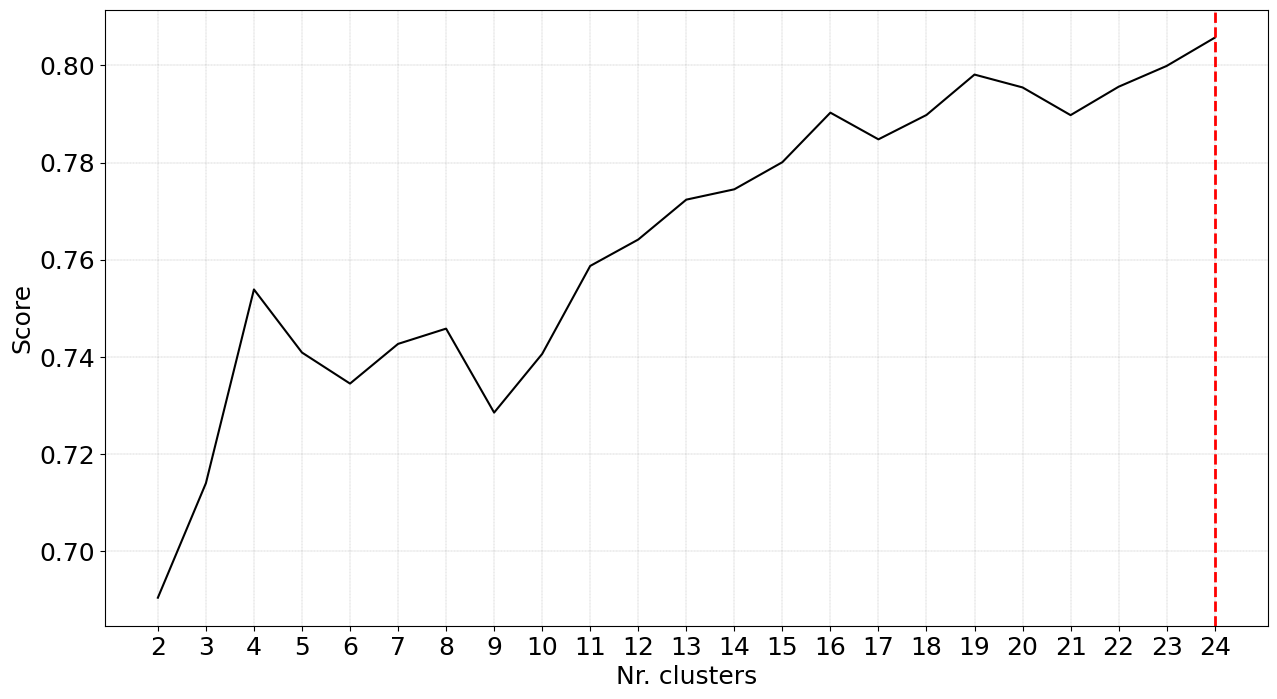

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [62]:
ce.plot()

# DBSCAN

In [63]:
base_dbscan = DBSCAN()
base_dbscan.fit(temp)

DBSCAN()

In [64]:
print("Estimated number of clusters:", set(base_dbscan.labels_))

Estimated number of clusters: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69),

In [65]:
print("Estimated number of noise points:", list(base_dbscan.labels_).count(-1))

Estimated number of noise points: 7871


In [66]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,base_dbscan.labels_)*100,2)) + '%')

Silhouette Score: -28.86%


In [67]:
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):
    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances[:,k-1], axis=0)
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.show()
    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    knee.plot_knee()
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.show()
    return distances[knee.knee]

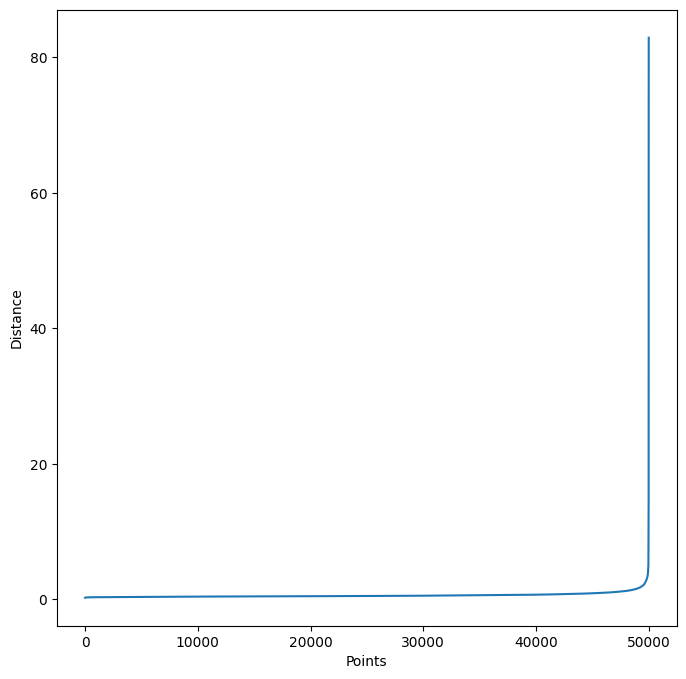

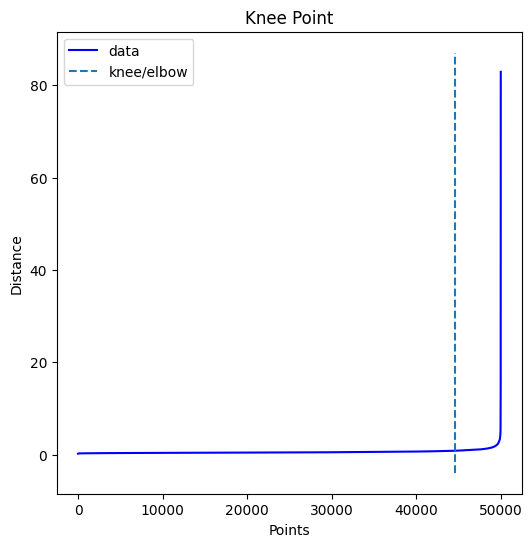

Knee Point: 0.8568944328710579


In [68]:
k = 2 * temp.shape[-1]
x = get_kdist_plot(temp,k)
print("Knee Point:",x)

In [69]:
ms = np.arange(3,2*temp.shape[1],3)
silhouette_scores = []

for i in ms:
    dbscan = DBSCAN(eps=x,min_samples=i)
    dbscan.fit(temp)
    silhouette_scores.append(silhouette_score(temp,dbscan.labels_))
    print("{} Minimum Samples Tested!".format(i))

3 Minimum Samples Tested!
6 Minimum Samples Tested!
9 Minimum Samples Tested!
12 Minimum Samples Tested!
15 Minimum Samples Tested!


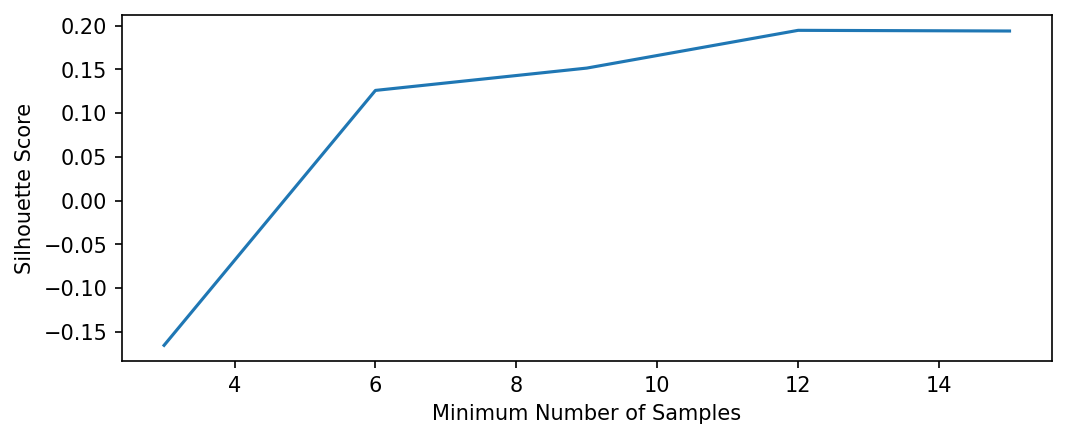

In [70]:
plt.figure(figsize=(8, 3), dpi=150)
sns.lineplot(x=ms, y=silhouette_scores)
plt.xlabel('Minimum Number of Samples')
plt.ylabel('Silhouette Score')
plt.show()

In [71]:
optimized_dbscan = DBSCAN(eps=x,min_samples=11)
optimized_dbscan.fit(temp)

DBSCAN(eps=np.float64(0.8568944328710579), min_samples=11)

In [72]:
print("Estimated number of clusters:",set(optimized_dbscan.labels_))

Estimated number of clusters: {np.int64(0), np.int64(1), np.int64(2), np.int64(-1)}


In [73]:
print("Estimated number of noise points:",list(optimized_dbscan.labels_).count(-1))

Estimated number of noise points: 2561


In [74]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,optimized_dbscan.labels_)*100,2)) + '%')

Silhouette Score: 17.88%


<Axes: xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

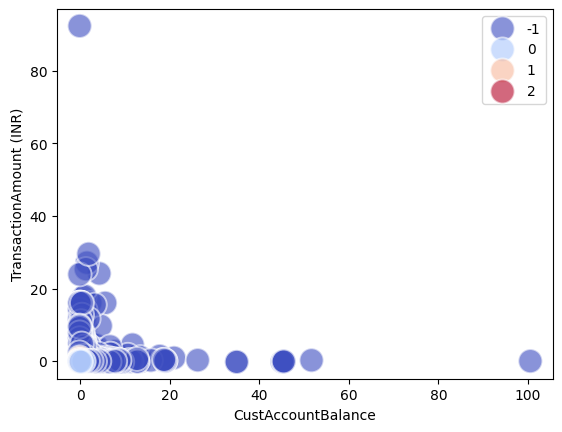

In [75]:
sns.scatterplot(data=temp,x='CustAccountBalance',y='TransactionAmount (INR)',hue=optimized_dbscan.labels_,s=300,alpha=0.6,palette='coolwarm')

In [76]:
temp['Cluster'] = optimized_dbscan.labels_

<Axes: xlabel='Cluster'>

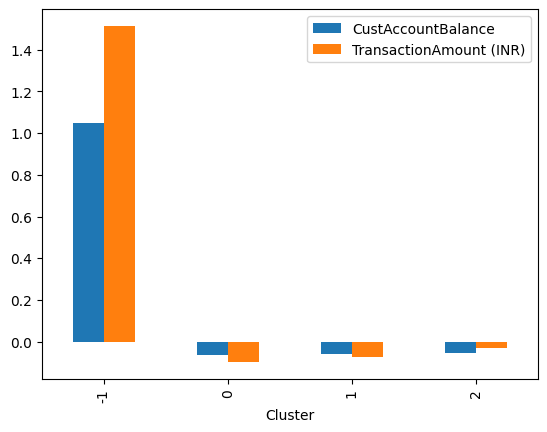

In [77]:
temp.groupby('Cluster')[['CustAccountBalance','TransactionAmount (INR)']].mean().plot(kind='bar')

# Determination of Optimum Epsilon Value for DBSCAN Model : 

In [78]:
temp = temp.sample(500)
ce = clusteval(cluster='dbscan',verbose=3)
results = ce.fit(np.reshape(np.ravel(temp),(-1,1)))
results

[09-09-2025 00:56:58] [clusteval.clusteval] [INFO] Saving data in memory.
[09-09-2025 00:56:58] [clusteval.clusteval] [INFO] Fit with method=[dbscan], metric=[euclidean], linkage=[ward]
[09-09-2025 00:56:59] [clusteval.dbscan] [INFO] Gridsearch across Epsilon.
[09-09-2025 00:56:59] [clusteval.dbscan] [INFO] Evaluate using silhouette..
[clusteval] >INFO: 100%|█████████████████████████████████████████████████████████████| 245/245 [04:35<00:00,  1.12s/it]
[09-09-2025 01:01:35] [clusteval.clusteval] [INFO] Compute dendrogram threshold.
[09-09-2025 01:01:35] [clusteval.clusteval] [INFO] Optimal number clusters detected: [2].
[09-09-2025 01:01:35] [clusteval.clusteval] [INFO] Fin.


{'labx': array([0, 0, 0, ..., 0, 0, 0], shape=(4500,)),
 'evaluate': 'dbscan',
 'fig': {'eps': array([0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 ,
         0.32, 0.34, 0.36, 0.38, 0.4 , 0.42, 0.44, 0.46, 0.48, 0.5 , 0.52,
         0.54, 0.56, 0.58, 0.6 , 0.62, 0.64, 0.66, 0.68, 0.7 , 0.72, 0.74,
         0.76, 0.78, 0.8 , 0.82, 0.84, 0.86, 0.88, 0.9 , 0.92, 0.94, 0.96,
         0.98, 1.  , 1.02, 1.04, 1.06, 1.08, 1.1 , 1.12, 1.14, 1.16, 1.18,
         1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 , 1.32, 1.34, 1.36, 1.38, 1.4 ,
         1.42, 1.44, 1.46, 1.48, 1.5 , 1.52, 1.54, 1.56, 1.58, 1.6 , 1.62,
         1.64, 1.66, 1.68, 1.7 , 1.72, 1.74, 1.76, 1.78, 1.8 , 1.82, 1.84,
         1.86, 1.88, 1.9 , 1.92, 1.94, 1.96, 1.98, 2.  , 2.02, 2.04, 2.06,
         2.08, 2.1 , 2.12, 2.14, 2.16, 2.18, 2.2 , 2.22, 2.24, 2.26, 2.28,
         2.3 , 2.32, 2.34, 2.36, 2.38, 2.4 , 2.42, 2.44, 2.46, 2.48, 2.5 ,
         2.52, 2.54, 2.56, 2.58, 2.6 , 2.62, 2.64, 2.66, 2.68, 2.7 , 2.72,
       

In [79]:
cluster_labels = results['labx']
cluster_labels

array([0, 0, 0, ..., 0, 0, 0], shape=(4500,))

In [80]:
print("Distinct Cluster Labels Detected:",np.unique(cluster_labels))

Distinct Cluster Labels Detected: [-1  0]


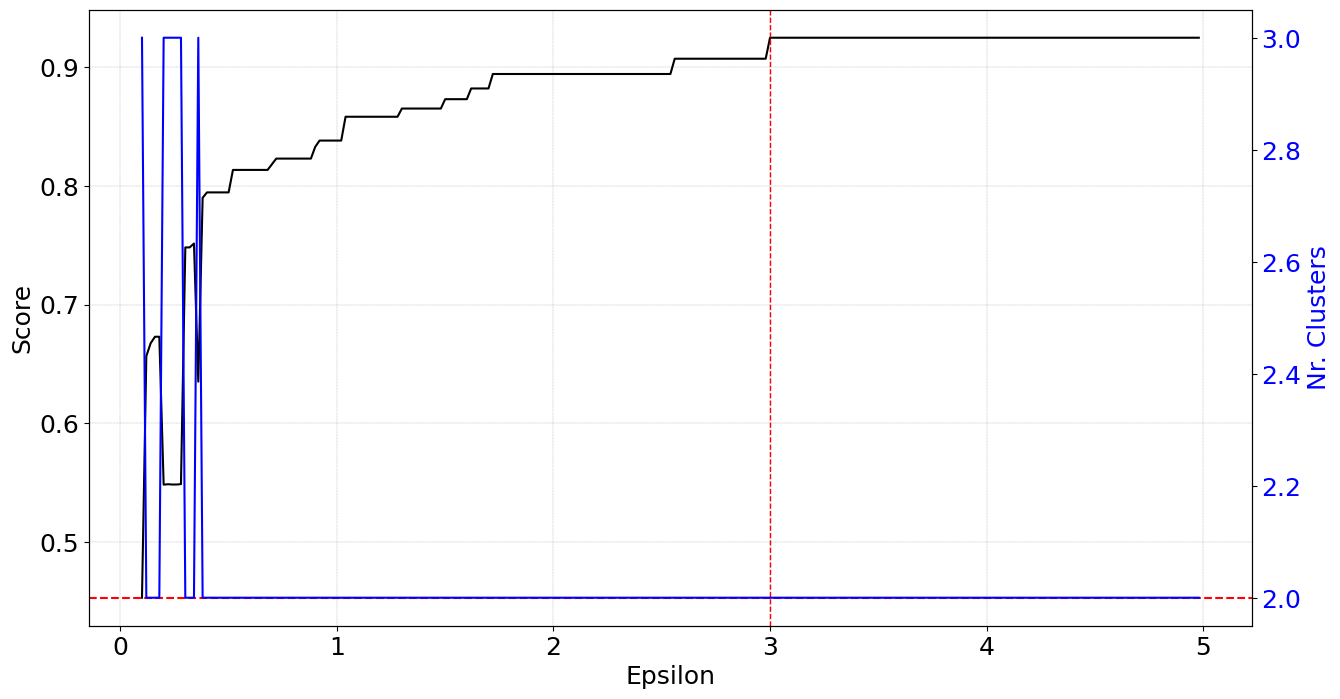

(<Figure size 1500x800 with 2 Axes>,
 (<Axes: xlabel='Epsilon', ylabel='Score'>, <Axes: ylabel='Nr. Clusters'>))

In [81]:
ce.plot()

In [82]:
enhanced_dbscan = DBSCAN(eps=3,min_samples=2*temp.shape[1])
enhanced_dbscan.fit(temp)

DBSCAN(eps=3, min_samples=18)

In [83]:
print("Estimated number of clusters:",len(set(enhanced_dbscan.labels_)),set(enhanced_dbscan.labels_))

Estimated number of clusters: 2 {np.int64(0), np.int64(-1)}


<Axes: xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

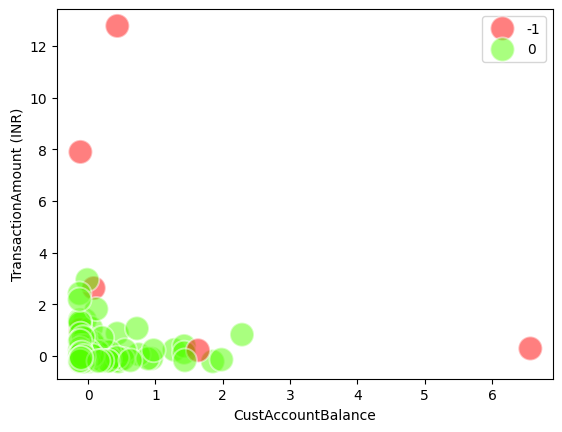

In [84]:
sns.scatterplot(data=temp,x='CustAccountBalance',y='TransactionAmount (INR)',hue=enhanced_dbscan.labels_,palette='prism',s=300,alpha=0.5)

In [85]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,enhanced_dbscan.labels_)*100,2)) + '%')

Silhouette Score: 50.36%


# Principal Component Analysis(PCA) :

In [86]:
temp = scaled_df.sample(10000)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(temp)
pca_components = pd.DataFrame(pca_components,columns=['PC1','PC2'])
pca_components.head()

,PC1,PC2
0,1.281080,-0.853429
1,-0.327099,-1.104141
2,0.367367,-0.831659
3,-1.029047,0.461361
4,0.431890,0.697350


In [87]:
base_spectral = SpectralClustering(random_state=101)

In [88]:
base_spectral.fit(pca_components)

SpectralClustering(random_state=101)

In [89]:
print("Estimated number of clusters:",len(set(base_spectral.labels_)))
print("Clusters:",set(base_spectral.labels_))

Estimated number of clusters: 8
Clusters: {np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7)}


In [90]:
pca_components['Cluster'] = base_spectral.labels_
print("Silhouette Score:",str(np.round(silhouette_score(pca_components,pca_components.Cluster)*100,2)) + '%')

Silhouette Score: 70.68%


<Axes: xlabel='PC1', ylabel='PC2'>

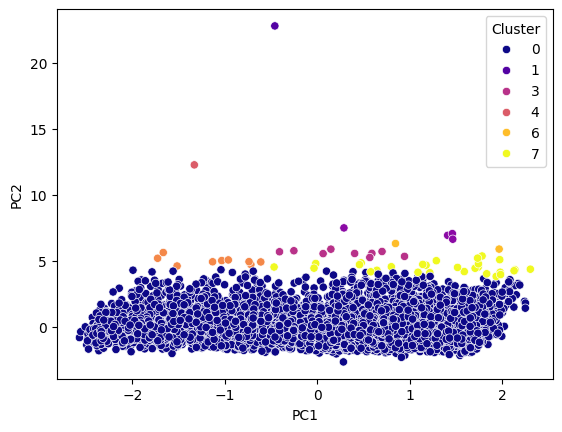

In [91]:
sns.scatterplot(x=pca_components['PC1'], y=pca_components['PC2'], hue=pca_components['Cluster'], palette='plasma')


<Axes: xlabel='Cluster'>

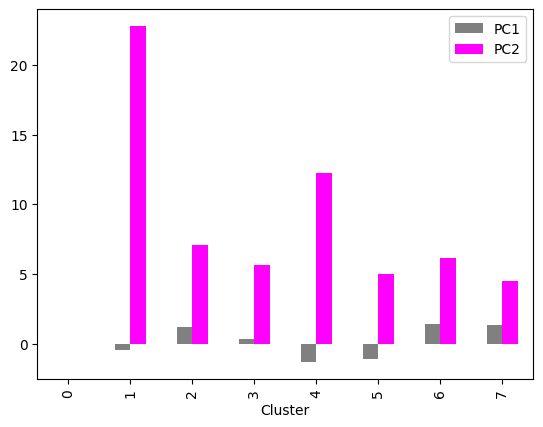

In [92]:
pca_components.groupby('Cluster')[['PC1','PC2']].mean().plot(kind='bar',color=['grey','magenta'])

# On Original Feature Space :

In [93]:
temp = scaled_df.sample(n=10000)

In [94]:
base_spectral = SpectralClustering(random_state=101)
base_spectral.fit(temp)

SpectralClustering(random_state=101)

In [95]:
print("Estimated number of clusters:",set(base_spectral.labels_))

Estimated number of clusters: {np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7)}


In [96]:
print("Estimated number of noise points:",list(base_spectral.labels_).count(-1))

Estimated number of noise points: 0


In [97]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,base_spectral.labels_)*100,2)) + '%')

Silhouette Score: 64.54%


<Axes: xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

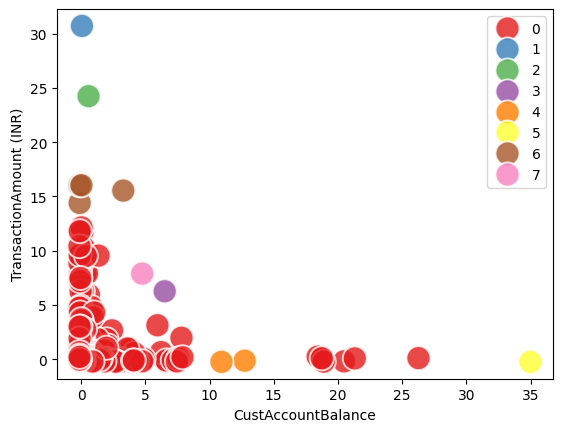

In [98]:
sns.scatterplot(data=temp,x='CustAccountBalance',y='TransactionAmount (INR)',hue=base_spectral.labels_,s=300,alpha=0.8,palette='Set1')

# Anomaly Detection On Transaction Data : 

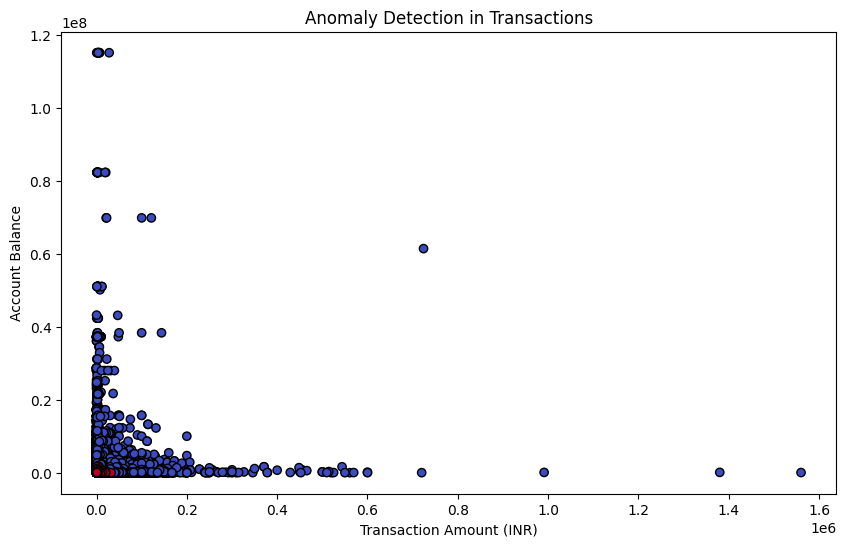

Number of Anomalies detected: 9869


In [99]:
from sklearn.ensemble import IsolationForest

# Features for anomaly detection
X = df[['TransactionAmount (INR)', 'CustAccountBalance']]

# Train an Isolation Forest model
model = IsolationForest(contamination=0.01, random_state=42)
df['anomaly'] = model.fit_predict(X)

# Visualize the anomalies
plt.figure(figsize=(10,6))
plt.scatter(df['TransactionAmount (INR)'], df['CustAccountBalance'], c=df['anomaly'], cmap='coolwarm', edgecolor='k')
plt.title('Anomaly Detection in Transactions')
plt.xlabel('Transaction Amount (INR)')
plt.ylabel('Account Balance')
plt.show()

# Number of anomalies detected
anomalies = df[df['anomaly'] == -1]
print(f"Number of Anomalies detected: {len(anomalies)}")